In [1]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank
import warnings
warnings.filterwarnings("ignore")

# Creating the spark session

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Alkemy_task2")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark

# Datasets manipulation

The objective is to extract a rank for products for each quarter (and November) based on the following values:
- Sold quantity for each product as percentage of the total quantity in the quarter
- Profit made by each product as percentage of the total profit in the quarter
- Frequency of transaction for each product (Sum of day in which the product has a transaction on the total of the days of the quarter)
- Sum of the regular clicks received in the quarter for each product
- Sum of the bidding clicks received in the quarter for each product
- Average of the stock values in the quarter for each products
- Average of the mark_up for single transactions made by each products in the quarter

In [3]:
#Loading the sales_data dataset
df = spark.read.csv(r"C:\Users\cosim\Desktop\BigData_off\all\sales_data.csv", header=True, inferSchema=True)
df.show()

+-------------------+----------+--------+---------------+-----------------+-----------+-------------+--------------+
|          sale_date|product_id|quantity|sales_price_tax|regular_price_tax|sales_price|regular_price|purchase_price|
+-------------------+----------+--------+---------------+-----------------+-----------+-------------+--------------+
|2021-01-02 00:00:00|    109751|       1|         2499.0|           2777.0|     2082.0|    2313.8917|        1499.4|
|2021-01-02 00:00:00|    110853|       1|         3990.0|           8322.0|     3325.0|    6935.1852|        2833.7|
|2021-01-02 00:00:00|    131410|       1|         2288.0|           3767.0|     1907.0|    3138.8889|        1860.0|
|2021-01-02 00:00:00|    134294|       1|         4990.0|           6666.0|     4158.0|    5554.6296|     3599.4024|
|2021-01-02 00:00:00|    134298|       1|         5990.0|           7777.0|     4992.0|    6480.5583|        4199.4|
|2021-01-02 00:00:00|    134814|       1|        10999.0|       

Computing for each transaction in sales_data the discount, the percentage of the discount, the transaction profit, the mark-up (the profit in percentage) and creating a column that we will use to take trace on how many days the specific product has been sold

In [4]:
df = df.withColumn('unit_discount', df.regular_price - df.sales_price)
df = df.withColumn('unit_discount', round('unit_discount',4))
df = df.withColumn('%_discount', round((df.unit_discount/df.regular_price)*100, 2))
df = df.withColumn('unit_profit', round(df.sales_price - df.purchase_price, 4))
df = df.withColumn('%_mark_up', round((df.unit_profit / df.purchase_price)*100, 2))
df = df.withColumn("date",to_date(col("sale_date"))).drop('sale_date')
df = df.withColumn('transaction_profit', round(df.unit_profit*df.quantity, 4))
df = df.withColumn('purc_signal', lit(1))
df = df.select('date','product_id','quantity','sales_price_tax','regular_price_tax','sales_price','regular_price','purchase_price','unit_discount','%_discount','unit_profit','transaction_profit','%_mark_up','purc_signal')

In [5]:
df.show()

+----------+----------+--------+---------------+-----------------+-----------+-------------+--------------+-------------+----------+-----------+------------------+---------+-----------+
|      date|product_id|quantity|sales_price_tax|regular_price_tax|sales_price|regular_price|purchase_price|unit_discount|%_discount|unit_profit|transaction_profit|%_mark_up|purc_signal|
+----------+----------+--------+---------------+-----------------+-----------+-------------+--------------+-------------+----------+-----------+------------------+---------+-----------+
|2021-01-02|    109751|       1|         2499.0|           2777.0|     2082.0|    2313.8917|        1499.4|     231.8917|     10.02|      582.6|             582.6|    38.86|          1|
|2021-01-02|    110853|       1|         3990.0|           8322.0|     3325.0|    6935.1852|        2833.7|    3610.1852|     52.06|      491.3|             491.3|    17.34|          1|
|2021-01-02|    131410|       1|         2288.0|           3767.0|    

## Manipulating clicks

To retrive the total number of clicks per product in each quarter

In [6]:
#For a specific product, a specific seller, in a specific day
#Loading the clicks_regular and clicks_bidding datasets, removing unecessary columns and selecting only 2021 and removing duplicated clicks between the two dataset with a leftanti join
clicks_r = spark.read.csv(r"C:\Users\cosim\Desktop\BigData_off\all\clicks_regular.csv", header=True, inferSchema=True)
clicks_b = spark.read.csv(r"C:\Users\cosim\Desktop\BigData_off\all\clicks_bidding.csv", header=True, inferSchema=True)
clicks_r = clicks_r.join(clicks_b, ["date", "seller",'product_id'], "leftanti")
r_2021 = clicks_r.filter((clicks_r.date >= '2021-01-01') & (clicks_r.date < '2022-01-01'))
b_2021 = clicks_b.filter(clicks_b.date < '2022-01-01')
#Filter only the seller 24
r_2021 = r_2021.filter(r_2021.seller == 24)
b_2021 = b_2021.filter(b_2021.seller == 24)

In [7]:
#Check for outliers
r_2021.groupBy('position').count().show(50,False)

+--------+------+
|position|count |
+--------+------+
|8.0     |6326  |
|0.0     |187   |
|7.0     |7688  |
|29.0    |7     |
|null    |23284 |
|18.0    |924   |
|1.0     |145720|
|25.0    |52    |
|4.0     |15858 |
|23.0    |166   |
|31.0    |2     |
|11.0    |3322  |
|106.0   |4     |
|21.0    |405   |
|14.0    |2010  |
|109.0   |1     |
|22.0    |278   |
|3.0     |29263 |
|19.0    |778   |
|28.0    |19    |
|2.0     |43766 |
|17.0    |1117  |
|27.0    |22    |
|10.0    |4023  |
|30.0    |2     |
|13.0    |2414  |
|6.0     |9524  |
|20.0    |548   |
|32.0    |1     |
|5.0     |11763 |
|15.0    |1623  |
|24.0    |99    |
|9.0     |4875  |
|26.0    |33    |
|16.0    |1310  |
|12.0    |2891  |
+--------+------+



Manipulating clicks regular dataset

In [8]:
# removing outliers values of position, i.e. position = 106 and 109
r_2021 = r_2021.filter((r_2021.position != 109) & (r_2021.position != 106))

r_2021 = r_2021.withColumn("click_date",to_date(col("date"))).drop('date')
r_2021 = r_2021.select('click_date', 'position','type','product_id')

# create a column of 1 to take trace if the product has received a click and how many in a day
r_2021 = r_2021.withColumn('clicks_number', lit(1))

# Computing the number of clicks per day for each product, and the average position regular and bidding
r_2021_g = r_2021.groupBy('click_date', 'product_id').agg(avg('position'), sum('clicks_number').alias('clicks_regular'))
r_2021_g = r_2021_g.withColumn('avg_position_regular', round('avg(position)',2)).drop('avg(position)')

r_2021_g.orderBy('click_date').show()

+----------+----------+--------------+--------------------+
|click_date|product_id|clicks_regular|avg_position_regular|
+----------+----------+--------------+--------------------+
|2021-01-18|    144347|             1|                 5.0|
|2021-01-18|    157636|             2|                 4.0|
|2021-01-18|    152553|             1|                 3.0|
|2021-01-18|    144517|             1|                 1.0|
|2021-01-18|    152876|             4|                 1.0|
|2021-01-18|    128559|             1|                 9.0|
|2021-01-18|    124486|             1|                 5.0|
|2021-01-18|    142051|             2|                15.0|
|2021-01-18|    125256|             4|                 1.0|
|2021-01-18|    154817|             1|                 3.0|
|2021-01-18|    139036|             1|                 9.0|
|2021-01-18|    144796|             1|                 2.0|
|2021-01-18|    148772|             2|                 3.0|
|2021-01-18|    108844|             1|  

Doing the sam operation on the clicks bidding dataset

In [9]:
b_2021 = b_2021.withColumn("click_date",to_date(col("date"))).drop('date')
b_2021 = b_2021.select('click_date', 'position','type','product_id')
b_2021 = b_2021.withColumn('clicks_number', lit(1))
b_2021_g = b_2021.groupBy('click_date', 'product_id').agg(avg('position'), sum('clicks_number').alias('clicks_bidding'))
b_2021_g = b_2021_g.withColumn('avg_position_bidding', round('avg(position)',2)).drop('avg(position)')
b_2021_g.orderBy('click_date').show()

+----------+----------+--------------+--------------------+
|click_date|product_id|clicks_bidding|avg_position_bidding|
+----------+----------+--------------+--------------------+
|2021-04-02|    143042|             7|                1.71|
|2021-04-02|    147706|             9|                2.22|
|2021-04-02|    144791|             1|                 3.0|
|2021-04-02|    143687|             1|                 3.0|
|2021-04-02|    143686|             1|                 1.0|
|2021-04-02|    131833|             2|                 1.5|
|2021-04-02|    155432|             2|                 1.5|
|2021-04-02|    161246|             1|                 1.0|
|2021-04-02|    135105|             1|                 1.0|
|2021-04-02|    134758|             4|                 1.5|
|2021-04-02|    158321|             1|                 2.0|
|2021-04-02|    141892|             1|                 2.0|
|2021-04-02|    151375|             1|                 1.0|
|2021-04-02|    112445|             2|  

Joining clicks regular and bidding

In [10]:
joined_clicks = b_2021_g.join(r_2021_g, ['click_date','product_id'], "outer")
joined_clicks.filter(joined_clicks.click_date > '2021-04-25').show(100,False)

+----------+----------+--------------+--------------------+--------------+--------------------+
|click_date|product_id|clicks_bidding|avg_position_bidding|clicks_regular|avg_position_regular|
+----------+----------+--------------+--------------------+--------------+--------------------+
|2021-04-26|100406    |1             |2.0                 |null          |null                |
|2021-04-26|100421    |null          |null                |1             |2.0                 |
|2021-04-26|100594    |1             |2.0                 |null          |null                |
|2021-04-26|100645    |null          |null                |1             |3.0                 |
|2021-04-26|100651    |1             |1.0                 |null          |null                |
|2021-04-26|100755    |null          |null                |1             |1.0                 |
|2021-04-26|100802    |null          |null                |1             |1.0                 |
|2021-04-26|103024    |1             |1.

In [11]:
print(f'number of rows joined = {joined_clicks.count()} < {r_2021_g.count() + b_2021_g.count()} = number of rows clicks_b + number of rows clicks_r')

number of rows joined = 295242 < 337593 = number of rows clicks_b + number of rows clicks_r


Since the number of rows in the joined dataset are less than the sum of the rows of the two single dataset, it means that in some days some products have received both clicks regular and clicks bidding. Still in some days for some products we have only clicks regular or bidding, that is why the dataset contains null values

In [12]:
joined_clicks = joined_clicks.withColumnRenamed('product_id', 'product_id_c')

## Joining clicks data with sales data

In [13]:
merged = df.join(joined_clicks, (df.date == joined_clicks.click_date) & (df.product_id == joined_clicks.product_id_c), how='left').drop('click_date', 'product_id_c')
merged.filter(merged.date > '2021-04-20').show()

+----------+----------+--------+---------------+-----------------+-----------+-------------+--------------+-------------+----------+-----------+------------------+---------+-----------+--------------+--------------------+--------------+--------------------+
|      date|product_id|quantity|sales_price_tax|regular_price_tax|sales_price|regular_price|purchase_price|unit_discount|%_discount|unit_profit|transaction_profit|%_mark_up|purc_signal|clicks_bidding|avg_position_bidding|clicks_regular|avg_position_regular|
+----------+----------+--------+---------------+-----------------+-----------+-------------+--------------+-------------+----------+-----------+------------------+---------+-----------+--------------+--------------------+--------------+--------------------+
|2021-04-21|    100044|       1|          556.0|            654.0|      463.0|     545.3704|         350.0|      82.3704|      15.1|      113.0|             113.0|    32.29|          1|          null|                null|     

## Adding stock information to the dataset

In [14]:
stock = spark.read.csv(r"C:\Users\cosim\Desktop\BigData_off\all\stock.csv", header=True, inferSchema=True)
stock.show()

+-------------------+----------+-----------+
|         stock_date|product_id|total_stock|
+-------------------+----------+-----------+
|2021-09-14 00:00:00|    136195|         12|
|2021-12-15 00:00:00|    121479|          4|
|2021-02-18 00:00:00|    133076|         52|
|2021-04-10 00:00:00|    160615|         20|
|2021-08-24 00:00:00|    100204|         24|
|2021-11-11 00:00:00|    120299|        143|
|2021-05-10 00:00:00|    139020|         40|
|2021-04-23 00:00:00|    163093|        184|
|2021-01-25 00:00:00|    159960|         10|
|2021-04-16 00:00:00|    161147|        216|
|2021-11-08 00:00:00|    163724|         10|
|2021-06-27 00:00:00|    128134|        105|
|2021-06-15 00:00:00|    109819|         15|
|2021-01-04 00:00:00|    147783|          7|
|2021-09-13 00:00:00|    103968|         34|
|2021-07-19 00:00:00|    143118|          4|
|2021-04-06 00:00:00|    142615|         14|
|2021-01-16 00:00:00|    132642|        151|
|2021-04-03 00:00:00|    157245|         55|
|2021-07-2

In [15]:
stock = stock.withColumn("date",to_date(col("stock_date"))).drop('stock_date')
final = merged.join(stock, ['date','product_id'], how='left')
final.filter(final.date > '2021-04-20').show()

+----------+----------+--------+---------------+-----------------+-----------+-------------+--------------+-------------+----------+-----------+------------------+---------+-----------+--------------+--------------------+--------------+--------------------+-----------+
|      date|product_id|quantity|sales_price_tax|regular_price_tax|sales_price|regular_price|purchase_price|unit_discount|%_discount|unit_profit|transaction_profit|%_mark_up|purc_signal|clicks_bidding|avg_position_bidding|clicks_regular|avg_position_regular|total_stock|
+----------+----------+--------+---------------+-----------------+-----------+-------------+--------------+-------------+----------+-----------+------------------+---------+-----------+--------------+--------------------+--------------+--------------------+-----------+
|2021-04-21|    100044|       1|          556.0|            654.0|      463.0|     545.3704|         350.0|      82.3704|      15.1|      113.0|             113.0|    32.29|          1|     

# Popularities index

The aim is to build different rank on which the products can be sorted

## First quarter

In [16]:
#Selecting the first quarter
first = final.filter(final.date < '2021-04-01')

Ranking the product on quantity:

Computing the total quantity sold for each product in the quarter, then computing the percentage of that quantity on the total quantity (considering all products) sold in the quarter

In [17]:
pop_q = first.groupBy('product_id').sum('quantity')
pop_q = pop_q.withColumnRenamed('sum(quantity)', 'quantity')
pop_q = pop_q.withColumn('popularity_q_%', round((pop_q.quantity/first.select('quantity').groupBy().sum().collect()[0][0])*100,6))
pop_q = pop_q.orderBy('quantity', ascending=False)
windowSpec = Window.orderBy(desc('popularity_q_%'))
pop_q = pop_q.withColumn("rank_quantity",dense_rank().over(windowSpec))
pop_q.show()

+----------+--------+--------------+-------------+
|product_id|quantity|popularity_q_%|rank_quantity|
+----------+--------+--------------+-------------+
|    110853|     502|      1.292316|            1|
|    156095|     258|      0.664178|            2|
|    107645|     178|      0.458231|            3|
|    145377|     164|      0.422191|            4|
|    157318|     158|      0.406745|            5|
|    143220|     146|      0.375853|            6|
|    155431|     141|      0.362981|            7|
|    157315|     134|      0.344961|            8|
|    122291|     130|      0.334663|            9|
|    128194|     129|      0.332089|           10|
|    125506|     122|      0.314069|           11|
|    157317|     117|      0.301197|           12|
|    132284|     117|      0.301197|           12|
|    124486|     115|      0.296048|           13|
|    121807|     113|        0.2909|           14|
|    132408|     112|      0.288325|           15|
|    139603|     100|      0.25

In [18]:
# Checking if the computation is correct
print('total % of popularity_q_% (should be equal or close to 100) = ',pop_q.select('popularity_q_%').groupBy().sum().collect()[0][0])

total % of popularity_q_% (should be equal or close to 100) =  99.99989099999617


Ranking the products on profit:

Total profit of one product on total profit (considering all products) of the quarter

In [19]:
pop_p = first.groupBy('product_id').sum('transaction_profit')
pop_p = pop_p.withColumnRenamed('sum(transaction_profit)','transaction_profit')
pop_p = pop_p.withColumn('transaction_profit', round(pop_p.transaction_profit,4))
pop_p = pop_p.withColumn('popularity_p_%', round((pop_p.transaction_profit/first.select('transaction_profit').groupBy().sum().collect()[0][0])*100,6))
pop_p = pop_p.orderBy('popularity_p_%', ascending = False)
windowSpec = Window.orderBy(desc('popularity_p_%'))
pop_p = pop_p.withColumn("rank_profit",dense_rank().over(windowSpec))
pop_p.show()

+----------+------------------+--------------+-----------+
|product_id|transaction_profit|popularity_p_%|rank_profit|
+----------+------------------+--------------+-----------+
|    156786|       461481.4372|      1.562355|          1|
|    160992|        419730.405|      1.421006|          2|
|    156411|          254172.6|      0.860507|          3|
|    155025|       190943.5305|      0.646443|          4|
|    155826|       190710.0009|      0.645653|          5|
|    110853|          157362.1|      0.532753|          6|
|    154812|        141845.892|      0.480222|          7|
|    154814|       133138.7063|      0.450744|          8|
|    132408|        130291.668|      0.441105|          9|
|    149306|       119021.0003|      0.402948|         10|
|    157410|        116576.752|      0.394673|         11|
|    109097|          111608.0|      0.377851|         12|
|    154218|       111591.2062|      0.377794|         13|
|    159547|          106948.0|      0.362075|         1

In [20]:
# Checking if the computation is correct
print('total % of popularity (should be equal or close to 100) = ',pop_p.select('popularity_p_%').groupBy().sum().collect()[0][0])

total % of popularity (should be equal or close to 100) =  99.99999199999951


Ranking the products on frequency:

Days in which a specific product is sold on total days of the quarter

In [21]:
pop_f = first.groupBy('product_id').sum('purc_signal')
pop_f = pop_f.withColumnRenamed('sum(purc_signal)', 'purc_signal')
pop_f = pop_f.withColumn('popularity_f_%', round(pop_f.purc_signal/first.select(countDistinct('date')).collect()[0][0]*100,6))
windowSpec = Window.orderBy(desc('popularity_f_%'))
pop_f = pop_f.withColumn("rank_frequency",dense_rank().over(windowSpec))
pop_f.show()

+----------+-----------+--------------+--------------+
|product_id|purc_signal|popularity_f_%|rank_frequency|
+----------+-----------+--------------+--------------+
|    110853|         69|     78.409091|             1|
|    107645|         56|     63.636364|             2|
|    157318|         53|     60.227273|             3|
|    143220|         50|     56.818182|             4|
|    145377|         49|     55.681818|             5|
|    156095|         48|     54.545455|             6|
|    125506|         47|     53.409091|             7|
|    157317|         47|     53.409091|             7|
|    132284|         47|     53.409091|             7|
|    128772|         46|     52.272727|             8|
|    122363|         44|          50.0|             9|
|    151475|         42|     47.727273|            10|
|    112437|         42|     47.727273|            10|
|    108871|         42|     47.727273|            10|
|    154553|         41|     46.590909|            11|
|    12432

Ranking the products on clicks and adding information about the average unit_cost of products (it will be used for the ABC analysis)

In [22]:
pop_c = first.groupBy('product_id').agg(sum('clicks_regular').alias('clicks_regular'),sum('clicks_bidding').alias('clicks_bidding'),round(avg('avg_position_regular'),2).alias('avg_position_regular'),round(avg('avg_position_bidding'),2).alias('avg_position_bidding'),round(avg('purchase_price'),4).alias('avg_unit_cost'))
pop_c = pop_c.withColumn('popularity_c_regular_%', round((pop_c.clicks_regular/first.select('clicks_regular').groupBy().sum().collect()[0][0])*100,6))
pop_c = pop_c.withColumn('popularity_c_bidding_%', round((pop_c.clicks_bidding/first.select('clicks_bidding').groupBy().sum().collect()[0][0])*100,6))
windowSpec = Window.orderBy(desc('popularity_c_regular_%'))
pop_c = pop_c.withColumn("rank_regular",dense_rank().over(windowSpec))
windowSpec = Window.orderBy(desc('popularity_c_bidding_%'))
pop_c = pop_c.withColumn("rank_bidding",dense_rank().over(windowSpec))
pop_c.show()

+----------+--------------+--------------+--------------------+--------------------+-------------+----------------------+----------------------+------------+------------+
|product_id|clicks_regular|clicks_bidding|avg_position_regular|avg_position_bidding|avg_unit_cost|popularity_c_regular_%|popularity_c_bidding_%|rank_regular|rank_bidding|
+----------+--------------+--------------+--------------------+--------------------+-------------+----------------------+----------------------+------------+------------+
|    156095|           509|          null|                1.61|                null|    2451.9227|              3.260104|                  null|           1|           1|
|    155431|           267|          null|                1.65|                null|    1433.3681|              1.710113|                  null|           2|           1|
|    154311|           244|          null|                4.58|                null|   33984.8252|                1.5628|                  null| 

Ranking the products on stock and mark-up:

The product with the higer average stock value in the quarter will be the first in the stock rank. The same logic works for the mark-up

In [23]:
pop_s = first.groupBy('product_id').agg(sum('total_stock').alias('total_stock'), round(avg('%_mark_up'),4).alias('avg_%_mark_up'))
windowSpec = Window.orderBy(desc('total_stock'))
pop_s = pop_s.withColumn("rank_stock",dense_rank().over(windowSpec))
windowSpec = Window.orderBy(desc('avg_%_mark_up'))
pop_s = pop_s.withColumn("rank_markup",dense_rank().over(windowSpec))
pop_s.show()

+----------+-----------+-------------+----------+-----------+
|product_id|total_stock|avg_%_mark_up|rank_stock|rank_markup|
+----------+-----------+-------------+----------+-----------+
|    143801|       7531|      315.468|        81|          1|
|    154603|        393|     290.3967|      1015|          2|
|    154605|        637|       289.78|       832|          3|
|    154604|         85|        280.5|      1315|          4|
|    160229|        487|      263.455|       935|          5|
|    154602|       4025|     256.2683|       174|          6|
|    127692|        427|      255.554|       985|          7|
|    136481|        310|       248.65|      1094|          8|
|    145110|       1722|       247.93|       415|          9|
|    160230|       2088|      238.455|       357|         10|
|    154607|        774|     238.4425|       748|         11|
|    136470|        281|     231.5067|      1120|         12|
|    136505|         83|       227.67|      1317|         13|
|    143

### Merging all the popularities computed for the first quarter

In [24]:
pop_first = pop_q.join(pop_p, ['product_id']).join(pop_f, ['product_id']).join(pop_c, ['product_id']).join(pop_s, ['product_id'])

## Second quarter

Doing the same computation made before for the second quarter

In [25]:
second = final.filter((final.date >= '2021-04-01') & (final.date < '2021-07-01'))

Ranking the product on quantity

In [26]:
pop_q = second.groupBy('product_id').sum('quantity')
pop_q = pop_q.withColumnRenamed('sum(quantity)', 'quantity')
pop_q = pop_q.withColumn('popularity_q_%', round((pop_q.quantity/second.select('quantity').groupBy().sum().collect()[0][0])*100,6))
pop_q = pop_q.orderBy('quantity', ascending=False)
windowSpec = Window.orderBy(desc('popularity_q_%'))
pop_q = pop_q.withColumn("rank_quantity",dense_rank().over(windowSpec))

In [27]:
print('total % of popularity (should be equal or close to 100) = ',pop_q.select('popularity_q_%').groupBy().sum().collect()[0][0])

total % of popularity (should be equal or close to 100) =  99.99913499999397


Ranking the products on profit

In [28]:
pop_p = second.groupBy('product_id').sum('transaction_profit')
pop_p = pop_p.withColumnRenamed('sum(transaction_profit)','transaction_profit')
pop_p = pop_p.withColumn('transaction_profit', round(pop_p.transaction_profit,4))
pop_p = pop_p.withColumn('popularity_p_%', round((pop_p.transaction_profit/second.select('transaction_profit').groupBy().sum().collect()[0][0])*100,6))
pop_p = pop_p.orderBy('popularity_p_%', ascending = False)
windowSpec = Window.orderBy(desc('popularity_p_%'))
pop_p = pop_p.withColumn("rank_profit",dense_rank().over(windowSpec))

In [29]:
print('total % of popularity (should be equal or close to 100) = ',pop_p.select('popularity_p_%').groupBy().sum().collect()[0][0])

total % of popularity (should be equal or close to 100) =  100.00001300000069


Ranking the products on frequency

In [30]:
pop_f = second.groupBy('product_id').sum('purc_signal')
pop_f = pop_f.withColumnRenamed('sum(purc_signal)', 'purc_signal')
pop_f = pop_f.withColumn('popularity_f_%', round(pop_f.purc_signal/second.select(countDistinct('date')).collect()[0][0]*100,6))
windowSpec = Window.orderBy(desc('popularity_f_%'))
pop_f = pop_f.withColumn("rank_frequency",dense_rank().over(windowSpec))

Ranking the products on clicks

In [31]:
pop_c = second.groupBy('product_id').agg(sum('clicks_regular').alias('clicks_regular'),sum('clicks_bidding').alias('clicks_bidding'),round(avg('avg_position_regular'),2).alias('avg_position_regular'),round(avg('avg_position_bidding'),2).alias('avg_position_bidding'),round(avg('purchase_price'),4).alias('avg_unit_cost'))
pop_c = pop_c.withColumn('popularity_c_regular_%', round((pop_c.clicks_regular/second.select('clicks_regular').groupBy().sum().collect()[0][0])*100,6))
pop_c = pop_c.withColumn('popularity_c_bidding_%', round((pop_c.clicks_bidding/second.select('clicks_bidding').groupBy().sum().collect()[0][0])*100,6))
windowSpec = Window.orderBy(desc('popularity_c_regular_%'))
pop_c = pop_c.withColumn("rank_regular",dense_rank().over(windowSpec))
windowSpec = Window.orderBy(desc('popularity_c_bidding_%'))
pop_c = pop_c.withColumn("rank_bidding",dense_rank().over(windowSpec))

Ranking products on stock and mark-up

In [32]:
pop_s = second.groupBy('product_id').agg(sum('total_stock').alias('total_stock'), round(avg('%_mark_up'),4).alias('avg_%_mark_up'))
windowSpec = Window.orderBy(desc('total_stock'))
pop_s = pop_s.withColumn("rank_stock",dense_rank().over(windowSpec))
windowSpec = Window.orderBy(desc('avg_%_mark_up'))
pop_s = pop_s.withColumn("rank_markup",dense_rank().over(windowSpec))

### Merging all the popularities

In [33]:
pop_second = pop_q.join(pop_p, ['product_id']).join(pop_f, ['product_id']).join(pop_c, ['product_id']).join(pop_s, ['product_id'])

## Third quarter

Same computations on the third quarter

In [34]:
third = final.filter((final.date >= '2021-07-01') & (final.date < '2021-10-01'))

Ranking the product on quantity

In [35]:
pop_q = third.groupBy('product_id').sum('quantity')
pop_q = pop_q.withColumnRenamed('sum(quantity)', 'quantity')
pop_q = pop_q.withColumn('popularity_q_%', round((pop_q.quantity/third.select('quantity').groupBy().sum().collect()[0][0])*100,6))
pop_q = pop_q.orderBy('quantity', ascending=False)
windowSpec = Window.orderBy(desc('popularity_q_%'))
pop_q = pop_q.withColumn("rank_quantity",dense_rank().over(windowSpec))

In [36]:
print('total % of popularity (should be equal or close to 100) = ',pop_q.select('popularity_q_%').groupBy().sum().collect()[0][0])

total % of popularity (should be equal or close to 100) =  100.00039299999952


Ranking the products on profit

In [37]:
pop_p = third.groupBy('product_id').sum('transaction_profit')
pop_p = pop_p.withColumnRenamed('sum(transaction_profit)','transaction_profit')
pop_p = pop_p.withColumn('transaction_profit', round(pop_p.transaction_profit,4))
pop_p = pop_p.withColumn('popularity_p_%', round((pop_p.transaction_profit/third.select('transaction_profit').groupBy().sum().collect()[0][0])*100,6))
pop_p = pop_p.orderBy('popularity_p_%', ascending = False)
windowSpec = Window.orderBy(desc('popularity_p_%'))
pop_p = pop_p.withColumn("rank_profit",dense_rank().over(windowSpec))

In [38]:
print('total % of popularity (should be equal or close to 100) = ',pop_p.select('popularity_p_%').groupBy().sum().collect()[0][0])

total % of popularity (should be equal or close to 100) =  99.99999599999965


Ranking the products on frequency

In [39]:
pop_f = third.groupBy('product_id').sum('purc_signal')
pop_f = pop_f.withColumnRenamed('sum(purc_signal)', 'purc_signal')
pop_f = pop_f.withColumn('popularity_f_%', round(pop_f.purc_signal/third.select(countDistinct('date')).collect()[0][0]*100,6))
windowSpec = Window.orderBy(desc('popularity_f_%'))
pop_f = pop_f.withColumn("rank_frequency",dense_rank().over(windowSpec))

Ranking the products on clicks

In [40]:
pop_c = third.groupBy('product_id').agg(sum('clicks_regular').alias('clicks_regular'),sum('clicks_bidding').alias('clicks_bidding'),round(avg('avg_position_regular'),2).alias('avg_position_regular'),round(avg('avg_position_bidding'),2).alias('avg_position_bidding'),round(avg('purchase_price'),4).alias('avg_unit_cost'))
pop_c = pop_c.withColumn('popularity_c_regular_%', round((pop_c.clicks_regular/third.select('clicks_regular').groupBy().sum().collect()[0][0])*100,6))
pop_c = pop_c.withColumn('popularity_c_bidding_%', round((pop_c.clicks_bidding/third.select('clicks_bidding').groupBy().sum().collect()[0][0])*100,6))
windowSpec = Window.orderBy(desc('popularity_c_regular_%'))
pop_c = pop_c.withColumn("rank_regular",dense_rank().over(windowSpec))
windowSpec = Window.orderBy(desc('popularity_c_bidding_%'))
pop_c = pop_c.withColumn("rank_bidding",dense_rank().over(windowSpec))

Ranking products on stock and mark-up

In [41]:
pop_s = third.groupBy('product_id').agg(sum('total_stock').alias('total_stock'), round(avg('%_mark_up'),4).alias('avg_%_mark_up'))
windowSpec = Window.orderBy(desc('total_stock'))
pop_s = pop_s.withColumn("rank_stock",dense_rank().over(windowSpec))
windowSpec = Window.orderBy(desc('avg_%_mark_up'))
pop_s = pop_s.withColumn("rank_markup",dense_rank().over(windowSpec))

### Merging all the popularities

In [42]:
pop_third = pop_q.join(pop_p, ['product_id']).join(pop_f, ['product_id']).join(pop_c, ['product_id']).join(pop_s, ['product_id'])

## Fourth quarter

Same computation on the fourth quarter

In [43]:
fourth = final.filter(final.date >= '2021-10-01')

Ranking the product on quantity

In [44]:
pop_q = fourth.groupBy('product_id').sum('quantity')
pop_q = pop_q.withColumnRenamed('sum(quantity)', 'quantity')
pop_q = pop_q.withColumn('popularity_q_%', round((pop_q.quantity/fourth.select('quantity').groupBy().sum().collect()[0][0])*100,6))
pop_q = pop_q.orderBy('quantity', ascending=False)
windowSpec = Window.orderBy(desc('popularity_q_%'))
pop_q = pop_q.withColumn("rank_quantity",dense_rank().over(windowSpec))

In [45]:
print('total % of popularity (should be equal or close to 100) = ',pop_q.select('popularity_q_%').groupBy().sum().collect()[0][0])

total % of popularity (should be equal or close to 100) =  100.0005630000055


Ranking the products on profit

In [46]:
pop_p = fourth.groupBy('product_id').sum('transaction_profit')
pop_p = pop_p.withColumnRenamed('sum(transaction_profit)','transaction_profit')
pop_p = pop_p.withColumn('transaction_profit', round(pop_p.transaction_profit,4))
pop_p = pop_p.withColumn('popularity_p_%', round((pop_p.transaction_profit/fourth.select('transaction_profit').groupBy().sum().collect()[0][0])*100,6))
pop_p = pop_p.orderBy('popularity_p_%', ascending = False)
windowSpec = Window.orderBy(desc('popularity_p_%'))
pop_p = pop_p.withColumn("rank_profit",dense_rank().over(windowSpec))

In [47]:
print('total % of popularity (should be equal or close to 100) = ',pop_p.select('popularity_p_%').groupBy().sum().collect()[0][0])

total % of popularity (should be equal or close to 100) =  99.99997200000028


Ranking the products on frequency

In [48]:
pop_f = fourth.groupBy('product_id').sum('purc_signal')
pop_f = pop_f.withColumnRenamed('sum(purc_signal)', 'purc_signal')
pop_f = pop_f.withColumn('popularity_f_%', round(pop_f.purc_signal/fourth.select(countDistinct('date')).collect()[0][0]*100,6))
windowSpec = Window.orderBy(desc('popularity_f_%'))
pop_f = pop_f.withColumn("rank_frequency",dense_rank().over(windowSpec))

Ranking the products on clicks

In [49]:
pop_c = fourth.groupBy('product_id').agg(sum('clicks_regular').alias('clicks_regular'),sum('clicks_bidding').alias('clicks_bidding'),round(avg('avg_position_regular'),2).alias('avg_position_regular'),round(avg('avg_position_bidding'),2).alias('avg_position_bidding'),round(avg('purchase_price'),4).alias('avg_unit_cost'))
pop_c = pop_c.withColumn('popularity_c_regular_%', round((pop_c.clicks_regular/fourth.select('clicks_regular').groupBy().sum().collect()[0][0])*100,6))
pop_c = pop_c.withColumn('popularity_c_bidding_%', round((pop_c.clicks_bidding/fourth.select('clicks_bidding').groupBy().sum().collect()[0][0])*100,6))
windowSpec = Window.orderBy(desc('popularity_c_regular_%'))
pop_c = pop_c.withColumn("rank_regular",dense_rank().over(windowSpec))
windowSpec = Window.orderBy(desc('popularity_c_bidding_%'))
pop_c = pop_c.withColumn("rank_bidding",dense_rank().over(windowSpec))

Ranking products on stock and mark-up

In [50]:
pop_s = fourth.groupBy('product_id').agg(sum('total_stock').alias('total_stock'), round(avg('%_mark_up'),4).alias('avg_%_mark_up'))
windowSpec = Window.orderBy(desc('total_stock'))
pop_s = pop_s.withColumn("rank_stock",dense_rank().over(windowSpec))
windowSpec = Window.orderBy(desc('avg_%_mark_up'))
pop_s = pop_s.withColumn("rank_markup",dense_rank().over(windowSpec))

### Merging all the popularities

In [51]:
pop_fourth = pop_q.join(pop_p, ['product_id']).join(pop_f, ['product_id']).join(pop_c, ['product_id']).join(pop_s, ['product_id'])

## November

In [52]:
november = final.filter((final.date >= '2021-11-01') & (final.date < '2021-11-30'))

Ranking the product on quantity

In [53]:
pop_q = november.groupBy('product_id').sum('quantity')
pop_q = pop_q.withColumnRenamed('sum(quantity)', 'quantity')
pop_q = pop_q.withColumn('popularity_q_%', round((pop_q.quantity/november.select('quantity').groupBy().sum().collect()[0][0])*100,6))
pop_q = pop_q.orderBy('quantity', ascending=False)
windowSpec = Window.orderBy(desc('popularity_q_%'))
pop_q = pop_q.withColumn("rank_quantity",dense_rank().over(windowSpec))

In [54]:
print('total % of popularity (should be equal or close to 100) = ',pop_q.select('popularity_q_%').groupBy().sum().collect()[0][0])

total % of popularity (should be equal or close to 100) =  99.99932699999538


Ranking the products on profit

In [55]:
pop_p = november.groupBy('product_id').sum('transaction_profit')
pop_p = pop_p.withColumnRenamed('sum(transaction_profit)','transaction_profit')
pop_p = pop_p.withColumn('transaction_profit', round(pop_p.transaction_profit,4))
pop_p = pop_p.withColumn('popularity_p_%', round((pop_p.transaction_profit/november.select('transaction_profit').groupBy().sum().collect()[0][0])*100,6))
pop_p = pop_p.orderBy('popularity_p_%', ascending = False)
windowSpec = Window.orderBy(desc('popularity_p_%'))
pop_p = pop_p.withColumn("rank_profit",dense_rank().over(windowSpec))

In [56]:
print('total % of popularity (should be equal or close to 100) = ',pop_p.select('popularity_p_%').groupBy().sum().collect()[0][0])

total % of popularity (should be equal or close to 100) =  99.99999500000006


Ranking the products on frequency

In [57]:
pop_f = november.groupBy('product_id').sum('purc_signal')
pop_f = pop_f.withColumnRenamed('sum(purc_signal)', 'purc_signal')
pop_f = pop_f.withColumn('popularity_f_%', round(pop_f.purc_signal/november.select(countDistinct('date')).collect()[0][0]*100,6))
windowSpec = Window.orderBy(desc('popularity_f_%'))
pop_f = pop_f.withColumn("rank_frequency",dense_rank().over(windowSpec))

Ranking the products on clicks

In [58]:
pop_c = november.groupBy('product_id').agg(sum('clicks_regular').alias('clicks_regular'),sum('clicks_bidding').alias('clicks_bidding'),round(avg('avg_position_regular'),2).alias('avg_position_regular'),round(avg('avg_position_bidding'),2).alias('avg_position_bidding'),round(avg('purchase_price'),4).alias('avg_unit_cost'))
pop_c = pop_c.withColumn('popularity_c_regular_%', round((pop_c.clicks_regular/november.select('clicks_regular').groupBy().sum().collect()[0][0])*100,6))
pop_c = pop_c.withColumn('popularity_c_bidding_%', round((pop_c.clicks_bidding/november.select('clicks_bidding').groupBy().sum().collect()[0][0])*100,6))
windowSpec = Window.orderBy(desc('popularity_c_regular_%'))
pop_c = pop_c.withColumn("rank_regular",dense_rank().over(windowSpec))
windowSpec = Window.orderBy(desc('popularity_c_bidding_%'))
pop_c = pop_c.withColumn("rank_bidding",dense_rank().over(windowSpec))

Ranking products on stock and mark-up

In [59]:
pop_s = november.groupBy('product_id').agg(sum('total_stock').alias('total_stock'), round(avg('%_mark_up'),4).alias('avg_%_mark_up'))
windowSpec = Window.orderBy(desc('total_stock'))
pop_s = pop_s.withColumn("rank_stock",dense_rank().over(windowSpec))
windowSpec = Window.orderBy(desc('avg_%_mark_up'))
pop_s = pop_s.withColumn("rank_markup",dense_rank().over(windowSpec))

### Merging all the popularities

In [60]:
pop_november = pop_q.join(pop_p, ['product_id']).join(pop_f, ['product_id']).join(pop_c, ['product_id']).join(pop_s, ['product_id'])

## Joining product_catalog

Adding the information about the product catalog to the popularities datasets

In [61]:
catalog = spark.read.csv(r"C:\Users\cosim\Desktop\BigData_off\all\product_catalog.csv", header=True, inferSchema=True)

In [62]:
pop_first = pop_first.join(catalog, ['product_id'], 'left')
pop_second = pop_second.join(catalog, ['product_id'], 'left')
pop_third = pop_third.join(catalog, ['product_id'], 'left')
pop_fourth = pop_fourth.join(catalog, ['product_id'], 'left')
pop_november = pop_november.join(catalog, ['product_id'], 'left')

## Popularities dataset

Showing the results of the computation

In [63]:
pop_first.show()

+----------+--------+--------------+-------------+------------------+--------------+-----------+-----------+--------------+--------------+--------------+--------------+--------------------+--------------------+-------------+----------------------+----------------------+------------+------------+-----------+-------------+----------+-----------+----------+----------+----------+-----------+----------+
|product_id|quantity|popularity_q_%|rank_quantity|transaction_profit|popularity_p_%|rank_profit|purc_signal|popularity_f_%|rank_frequency|clicks_regular|clicks_bidding|avg_position_regular|avg_position_bidding|avg_unit_cost|popularity_c_regular_%|popularity_c_bidding_%|rank_regular|rank_bidding|total_stock|avg_%_mark_up|rank_stock|rank_markup|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+--------+--------------+-------------+------------------+--------------+-----------+-----------+--------------+--------------+--------------+--------------+--------------------+-------

In [64]:
pop_second.show()

+----------+--------+--------------+-------------+------------------+--------------+-----------+-----------+--------------+--------------+--------------+--------------+--------------------+--------------------+-------------+----------------------+----------------------+------------+------------+-----------+-------------+----------+-----------+----------+----------+----------+-----------+----------+
|product_id|quantity|popularity_q_%|rank_quantity|transaction_profit|popularity_p_%|rank_profit|purc_signal|popularity_f_%|rank_frequency|clicks_regular|clicks_bidding|avg_position_regular|avg_position_bidding|avg_unit_cost|popularity_c_regular_%|popularity_c_bidding_%|rank_regular|rank_bidding|total_stock|avg_%_mark_up|rank_stock|rank_markup|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+--------+--------------+-------------+------------------+--------------+-----------+-----------+--------------+--------------+--------------+--------------+--------------------+-------

In [65]:
pop_third.show()

+----------+--------+--------------+-------------+------------------+--------------+-----------+-----------+--------------+--------------+--------------+--------------+--------------------+--------------------+-------------+----------------------+----------------------+------------+------------+-----------+-------------+----------+-----------+----------+----------+----------+-----------+----------+
|product_id|quantity|popularity_q_%|rank_quantity|transaction_profit|popularity_p_%|rank_profit|purc_signal|popularity_f_%|rank_frequency|clicks_regular|clicks_bidding|avg_position_regular|avg_position_bidding|avg_unit_cost|popularity_c_regular_%|popularity_c_bidding_%|rank_regular|rank_bidding|total_stock|avg_%_mark_up|rank_stock|rank_markup|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+--------+--------------+-------------+------------------+--------------+-----------+-----------+--------------+--------------+--------------+--------------+--------------------+-------

In [66]:
pop_fourth.show()

+----------+--------+--------------+-------------+------------------+--------------+-----------+-----------+--------------+--------------+--------------+--------------+--------------------+--------------------+-------------+----------------------+----------------------+------------+------------+-----------+-------------+----------+-----------+----------+----------+----------+-----------+----------+
|product_id|quantity|popularity_q_%|rank_quantity|transaction_profit|popularity_p_%|rank_profit|purc_signal|popularity_f_%|rank_frequency|clicks_regular|clicks_bidding|avg_position_regular|avg_position_bidding|avg_unit_cost|popularity_c_regular_%|popularity_c_bidding_%|rank_regular|rank_bidding|total_stock|avg_%_mark_up|rank_stock|rank_markup|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+--------+--------------+-------------+------------------+--------------+-----------+-----------+--------------+--------------+--------------+--------------+--------------------+-------

In [67]:
pop_november.show()

+----------+--------+--------------+-------------+------------------+--------------+-----------+-----------+--------------+--------------+--------------+--------------+--------------------+--------------------+-------------+----------------------+----------------------+------------+------------+-----------+-------------+----------+-----------+----------+----------+----------+-----------+----------+
|product_id|quantity|popularity_q_%|rank_quantity|transaction_profit|popularity_p_%|rank_profit|purc_signal|popularity_f_%|rank_frequency|clicks_regular|clicks_bidding|avg_position_regular|avg_position_bidding|avg_unit_cost|popularity_c_regular_%|popularity_c_bidding_%|rank_regular|rank_bidding|total_stock|avg_%_mark_up|rank_stock|rank_markup|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+--------+--------------+-------------+------------------+--------------+-----------+-----------+--------------+--------------+--------------+--------------+--------------------+-------

# Switch to Python

Moving the dataset from Pyspark DataFrame to Pandas to use the power of python for further computations 

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [69]:
first_p = pop_first.toPandas()
second_p = pop_second.toPandas()
third_p = pop_third.toPandas()
fourth_p = pop_fourth.toPandas()
nov_p = pop_november.toPandas()

In [70]:
spark.stop

<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x000001C99D2CE9B0>>

# ABC Analysis

Performing an ABC analysis for inventory management.

We created a code that performs ABC analysis on any given unit cost (based on purchase cost) and demand data (based on the quantity sold). The aim of the function is to classify as A the first 10% of demanded product that accounts for around 60% of the value of the inventory, as B the following 20% of items that account for around 30% of the value and as C the remaining 70% of products that account for the remaining 10% of the inventory value.
The function returns a dataset with the products sorted by quarter use, and arrays containing the names of the items for each category A, B or C. In this way the dataset of each class can be printed.
Finally, a matrix is calculated in which  is summarised the division of the products into categories and how much of the quarter_use is in each category. A graph representing it, in which we can see, for every 10% increase in the number of items, how much the quarter use increases. In fact, we see that the curve is steeper for the first products, and then flattens out, meaning that the last products have the lowest values of quarter use.

## First Quarter

Executing the ABC analysis for the first quarter

In [71]:
def ABC_items_pct(item, unit_cost, demand, A_size: int=10, B_size: int=30 )->'Group A B C':
    """This function assigns every item to group A B and C"""
    
    """Creates a Pandas Dataframe with the columns 'item','unit_cost' and 'demand' """
    df = pd.DataFrame(data=[item,unit_cost,demand],index=['item', 'unit_cost', 'demand']).T
    
    """Find the value of each product"""
    df['quarter_use'] = df['unit_cost']*df['demand']
    
    """Sorted the products based on their values"""
    df.sort_values(by='quarter_use',ascending=False, inplace=True)
    df.reset_index(drop = True, inplace=True)
    
    """Find the cumulative value of the items"""
    df['cumulative_%_of_items'] = ((1/len(df.item))*(df.index +1)*100).astype(int)
    df['cumulative_use']=np.cumsum(df['quarter_use'])
    df['%_of_use'] = (df.quarter_use/df['cumulative_use'].iloc[-1])*100
    df['cumulative_%_of_quarter_use'] = (np.cumsum(df.quarter_use/df['cumulative_use'].iloc[-1]))*100
    
    """Cut the items into the 3 groups: A,B and C"""
    group_A = df[df['cumulative_%_of_items'] <= A_size].item.values
    group_B = df[(df['cumulative_%_of_items'] > A_size) & (df['cumulative_%_of_items'] <= B_size)].item.values
    group_C = df[df['cumulative_%_of_items'] > B_size].item.values


    return df,group_A, group_B, group_C

In [72]:
df, A, B, C = ABC_items_pct(first_p['product_id'].astype(str), first_p['avg_unit_cost'].astype(float), first_p['quantity'].astype(int))

df.set_index(df['item'], inplace=True)
df.drop('item',axis=1,inplace=True)

In [73]:
A = A.astype(str)
B = B.astype(str)
C = C.astype(str)
df.index = df.index.astype(str)

In [74]:
category = {'category':['A','B','C'], 
            'percentage_of_items':[df.loc[A]['cumulative_%_of_items'][-1],(df.loc[B]['cumulative_%_of_items'][-1])-(df.loc[A]['cumulative_%_of_items'][-1]),(df.loc[C]['cumulative_%_of_items'][-1])-(df.loc[B]['cumulative_%_of_items'][-1])]}
cat = pd.DataFrame(category)
cat['cumulative_percentage_of_items'] = np.cumsum(cat['percentage_of_items'])
cat['percentage_of_use_by_value'] = [np.sum(df.loc[A]['%_of_use']),np.sum(df.loc[B]['%_of_use']),np.sum(df.loc[C]['%_of_use'])]
cat['cumulative_percentage_of_use_by_value'] = np.cumsum(cat['percentage_of_use_by_value'])
cat

,category,percentage_of_items,cumulative_percentage_of_items,percentage_of_use_by_value,cumulative_percentage_of_use_by_value
0,A,10,10,59.519544,59.519544
1,B,20,30,27.694776,87.214321
2,C,70,100,12.785679,100.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


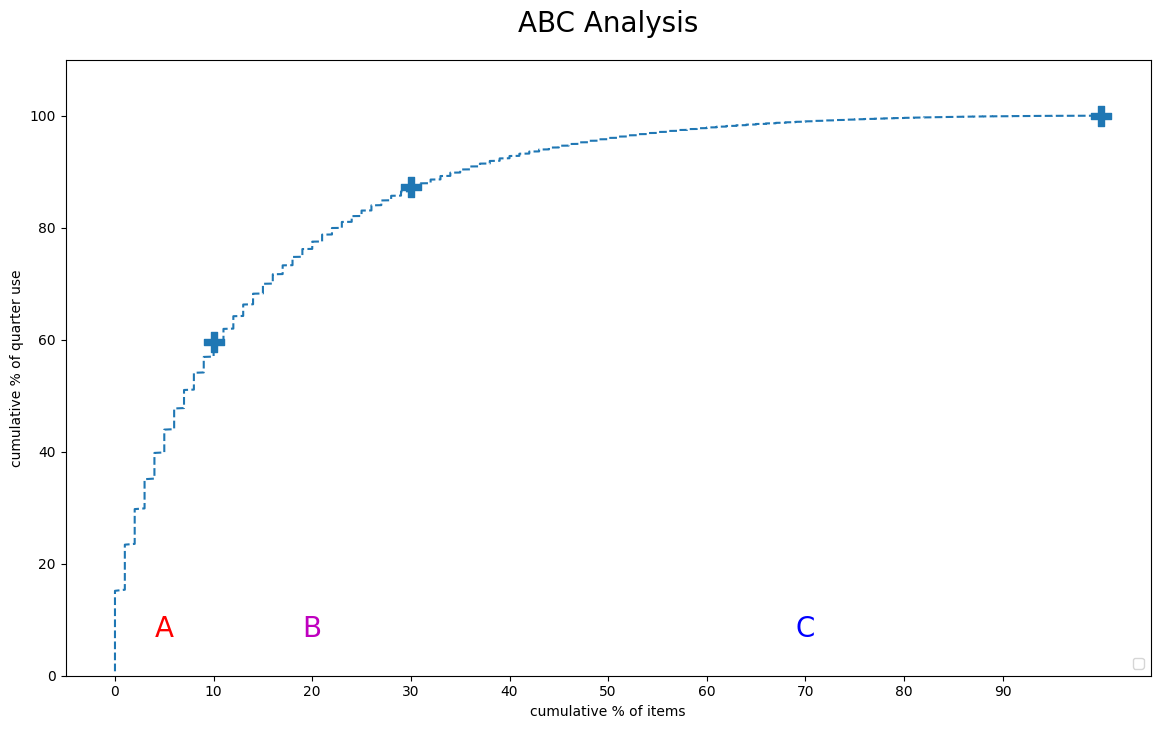

In [75]:
plt.figure(figsize=(14,8))
plt.plot(df['cumulative_%_of_items'], df['cumulative_%_of_quarter_use'],linestyle='dashed')
plt.ylim(0,110)
plt.xlabel('cumulative % of items')
plt.ylabel('cumulative % of quarter use')
plt.scatter(cat['cumulative_percentage_of_items'], cat['cumulative_percentage_of_use_by_value'],s=200,marker='P')
#plt.axvline(10,ymax=0.18,color='r',label='10%')
#plt.axvline(30,ymax=0.442,color='m',label='30%')
#plt.axhline(y=cat['cumulative_percentage_of_use_by_value'][0],xmax=0.09,color='r')
#plt.axhline(y=cat['cumulative_percentage_of_use_by_value'][1],xmax=0.28,color='m')
plt.legend(loc='lower right')
plt.title('ABC Analysis',size=20,pad=20)
plt.annotate('A',xy=(10,10),xytext=(4,7),size=20,color='r')
plt.annotate('B',xy=(10,10),xytext=(19,7),size=20,color='m')
plt.annotate('C',xy=(10,10),xytext=(69,7),size=20,color='b')
_=plt.xticks(np.arange(0,100,10))

Adding the information about the classification in A, B or C of each products in the dataset. Another column with value = 1 for each A product, 2 for each B product and 3 for each C product is added 

In [76]:
new = {}
for i in A:
  new[i] = 'A'
for j in B:
  new[j] = 'B'
for z in C:
  new[z] = 'C'

first_p['product_id'] = first_p['product_id'].astype(str)
first_p["classe"]=first_p["product_id"].map(new)
first_p['class_num'] = np.NaN

counter = 0
for i in first_p.classe:
  if i == 'A':
    first_p['class_num'][counter] = int(1)
  if i == 'B':
    first_p['class_num'][counter] = int(2)
  if i == 'C':
    first_p['class_num'][counter] = int(3)
  counter += 1 

first_p

,product_id,quantity,popularity_q_%,rank_quantity,transaction_profit,popularity_p_%,rank_profit,purc_signal,popularity_f_%,rank_frequency,...,avg_%_mark_up,rank_stock,rank_markup,coded_cat1,coded_cat2,coded_cat3,coded_brand,coded_name,classe,class_num
0,110853,502,1.292316,1,157362.1000,0.532753,6,69,78.409091,1,...,12.7599,17,2337,2259,2015,493,522,1709,A,1.0
1,156095,258,0.664178,2,85093.7541,0.288087,31,48,54.545455,6,...,14.9740,2,2105,1163,1267,1176,547,2933,A,1.0
2,107645,178,0.458231,3,31907.3800,0.108023,228,56,63.636364,2,...,14.5062,9,2151,2259,1714,720,522,1782,A,1.0
3,145377,164,0.422191,4,34111.5000,0.115485,204,49,55.681818,5,...,24.2324,13,1328,1375,2519,2668,685,2489,B,2.0
4,157318,158,0.406745,5,67070.4000,0.227068,44,53,60.227273,3,...,13.0917,38,2291,2259,1714,647,522,1825,A,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782,159983,1,0.002574,100,216.0000,0.000731,3586,1,1.136364,51,...,18.0000,1400,1811,1776,1376,694,443,1690,C,3.0
4783,140472,1,0.002574,100,312.0000,0.001056,3491,1,1.136364,51,...,20.5300,1393,1602,1776,1773,1773,730,3251,C,3.0
4784,158028,1,0.002574,100,-1333.0000,-0.004513,4003,1,1.136364,51,...,-13.8200,1400,4036,2880,806,902,367,1944,C,3.0
4785,108946,1,0.002574,100,3049.0000,0.010322,2018,1,1.136364,51,...,23.1000,1391,1410,2180,834,1088,453,1680,C,3.0


## Second Quarter

Same computation for ABC analysis on the second quarter

In [77]:
df, A, B, C = ABC_items_pct(second_p['product_id'].astype(str), second_p['avg_unit_cost'].astype(float), second_p['quantity'].astype(int))

df.set_index(df['item'], inplace=True)
df.drop('item',axis=1,inplace=True)

In [78]:
A = A.astype(str)
B = B.astype(str)
C = C.astype(str)
df.index = df.index.astype(str)

In [79]:
category = {'category':['A','B','C'], 
            'percentage_of_items':[df.loc[A]['cumulative_%_of_items'][-1],(df.loc[B]['cumulative_%_of_items'][-1])-(df.loc[A]['cumulative_%_of_items'][-1]),(df.loc[C]['cumulative_%_of_items'][-1])-(df.loc[B]['cumulative_%_of_items'][-1])]}
cat = pd.DataFrame(category)
cat['cumulative_percentage_of_items'] = np.cumsum(cat['percentage_of_items'])
cat['percentage_of_use_by_value'] = [np.sum(df.loc[A]['%_of_use']),np.sum(df.loc[B]['%_of_use']),np.sum(df.loc[C]['%_of_use'])]
cat['cumulative_percentage_of_use_by_value'] = np.cumsum(cat['percentage_of_use_by_value'])
cat

,category,percentage_of_items,cumulative_percentage_of_items,percentage_of_use_by_value,cumulative_percentage_of_use_by_value
0,A,10,10,63.180485,63.180485
1,B,20,30,24.818025,87.998509
2,C,70,100,12.001491,100.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


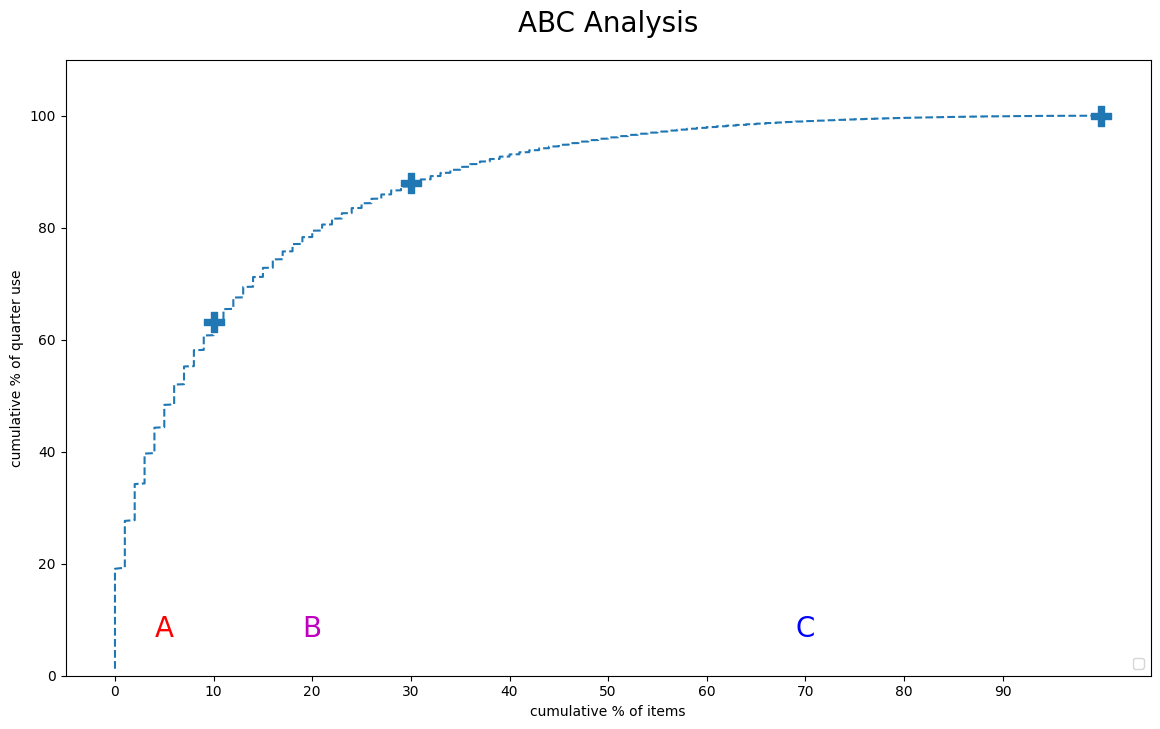

In [81]:
plt.figure(figsize=(14,8))
plt.plot(df['cumulative_%_of_items'], df['cumulative_%_of_quarter_use'],linestyle='dashed')
plt.ylim(0,110)
plt.xlabel('cumulative % of items')
plt.ylabel('cumulative % of quarter use')
plt.scatter(cat['cumulative_percentage_of_items'], cat['cumulative_percentage_of_use_by_value'],s=200,marker='P')
#plt.axvline(10,ymax=0.18,color='r',label='10%')
#plt.axvline(30,ymax=0.442,color='m',label='30%')
#plt.axhline(y=cat['cumulative_percentage_of_use_by_value'][0],xmax=0.09,color='r')
#plt.axhline(y=cat['cumulative_percentage_of_use_by_value'][1],xmax=0.28,color='m')
plt.legend(loc='lower right')
plt.title('ABC Analysis',size=20,pad=20)
plt.annotate('A',xy=(10,10),xytext=(4,7),size=20,color='r')
plt.annotate('B',xy=(10,10),xytext=(19,7),size=20,color='m')
plt.annotate('C',xy=(10,10),xytext=(69,7),size=20,color='b')
_=plt.xticks(np.arange(0,100,10))

In [82]:
new = {}
for i in A:
  new[i] = 'A'
for j in B:
  new[j] = 'B'
for z in C:
  new[z] = 'C'

second_p['product_id'] = second_p['product_id'].astype(str)
second_p["classe"]=second_p["product_id"].map(new)
second_p['class_num'] = np.NaN

counter = 0
for i in second_p.classe:
  if i == 'A':
    second_p['class_num'][counter] = int(1)
  if i == 'B':
    second_p['class_num'][counter] = int(2)
  if i == 'C':
    second_p['class_num'][counter] = int(3)
  counter += 1 

## Third Quarter

Same computation for ABC analysis on the third quarter

In [83]:
df, A, B, C = ABC_items_pct(third_p['product_id'].astype(str), third_p['avg_unit_cost'].astype(float), third_p['quantity'].astype(int))

df.set_index(df['item'], inplace=True)
df.drop('item',axis=1,inplace=True)

In [84]:
A = A.astype(str)
B = B.astype(str)
C = C.astype(str)
df.index = df.index.astype(str)

In [85]:
category = {'category':['A','B','C'], 
            'percentage_of_items':[df.loc[A]['cumulative_%_of_items'][-1],(df.loc[B]['cumulative_%_of_items'][-1])-(df.loc[A]['cumulative_%_of_items'][-1]),(df.loc[C]['cumulative_%_of_items'][-1])-(df.loc[B]['cumulative_%_of_items'][-1])]}
cat = pd.DataFrame(category)
cat['cumulative_percentage_of_items'] = np.cumsum(cat['percentage_of_items'])
cat['percentage_of_use_by_value'] = [np.sum(df.loc[A]['%_of_use']),np.sum(df.loc[B]['%_of_use']),np.sum(df.loc[C]['%_of_use'])]
cat['cumulative_percentage_of_use_by_value'] = np.cumsum(cat['percentage_of_use_by_value'])
cat

,category,percentage_of_items,cumulative_percentage_of_items,percentage_of_use_by_value,cumulative_percentage_of_use_by_value
0,A,10,10,63.574863,63.574863
1,B,20,30,25.303911,88.878774
2,C,70,100,11.121226,100.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


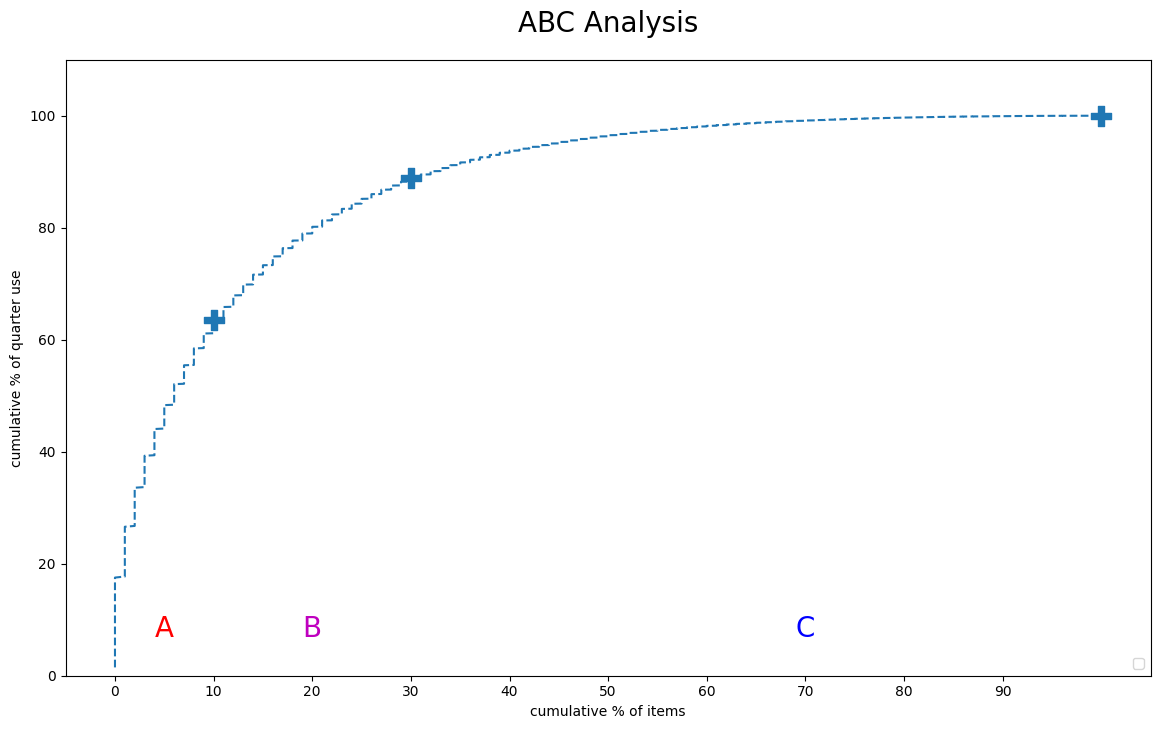

In [86]:
plt.figure(figsize=(14,8))
plt.plot(df['cumulative_%_of_items'], df['cumulative_%_of_quarter_use'],linestyle='dashed')
plt.ylim(0,110)
plt.xlabel('cumulative % of items')
plt.ylabel('cumulative % of quarter use')
plt.scatter(cat['cumulative_percentage_of_items'], cat['cumulative_percentage_of_use_by_value'],s=200,marker='P')
#plt.axvline(10,ymax=0.18,color='r',label='10%')
#plt.axvline(30,ymax=0.442,color='m',label='30%')
#plt.axhline(y=cat['cumulative_percentage_of_use_by_value'][0],xmax=0.09,color='r')
#plt.axhline(y=cat['cumulative_percentage_of_use_by_value'][1],xmax=0.28,color='m')
plt.legend(loc='lower right')
plt.title('ABC Analysis',size=20,pad=20)
plt.annotate('A',xy=(10,10),xytext=(4,7),size=20,color='r')
plt.annotate('B',xy=(10,10),xytext=(19,7),size=20,color='m')
plt.annotate('C',xy=(10,10),xytext=(69,7),size=20,color='b')
_=plt.xticks(np.arange(0,100,10))

In [87]:
new = {}
for i in A:
  new[i] = 'A'
for j in B:
  new[j] = 'B'
for z in C:
  new[z] = 'C'

third_p['product_id'] = third_p['product_id'].astype(str)
third_p["classe"]=third_p["product_id"].map(new)
third_p['class_num'] = np.NaN

counter = 0
for i in third_p.classe:
  if i == 'A':
    third_p['class_num'][counter] = int(1)
  if i == 'B':
    third_p['class_num'][counter] = int(2)
  if i == 'C':
    third_p['class_num'][counter] = int(3)
  counter += 1 

## Fourth Quarter

Same computation for ABC analysis on the fourth quarter

In [88]:
df, A, B, C = ABC_items_pct(fourth_p['product_id'].astype(str), fourth_p['avg_unit_cost'].astype(float), fourth_p['quantity'].astype(int))

df.set_index(df['item'], inplace=True)
df.drop('item',axis=1,inplace=True)

In [89]:
A = A.astype(str)
B = B.astype(str)
C = C.astype(str)
df.index = df.index.astype(str)

In [90]:
category = {'category':['A','B','C'], 
            'percentage_of_items':[df.loc[A]['cumulative_%_of_items'][-1],(df.loc[B]['cumulative_%_of_items'][-1])-(df.loc[A]['cumulative_%_of_items'][-1]),(df.loc[C]['cumulative_%_of_items'][-1])-(df.loc[B]['cumulative_%_of_items'][-1])]}
cat = pd.DataFrame(category)
cat['cumulative_percentage_of_items'] = np.cumsum(cat['percentage_of_items'])
cat['percentage_of_use_by_value'] = [np.sum(df.loc[A]['%_of_use']),np.sum(df.loc[B]['%_of_use']),np.sum(df.loc[C]['%_of_use'])]
cat['cumulative_percentage_of_use_by_value'] = np.cumsum(cat['percentage_of_use_by_value'])
cat

,category,percentage_of_items,cumulative_percentage_of_items,percentage_of_use_by_value,cumulative_percentage_of_use_by_value
0,A,10,10,64.305071,64.305071
1,B,20,30,24.454684,88.759755
2,C,70,100,11.240245,100.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


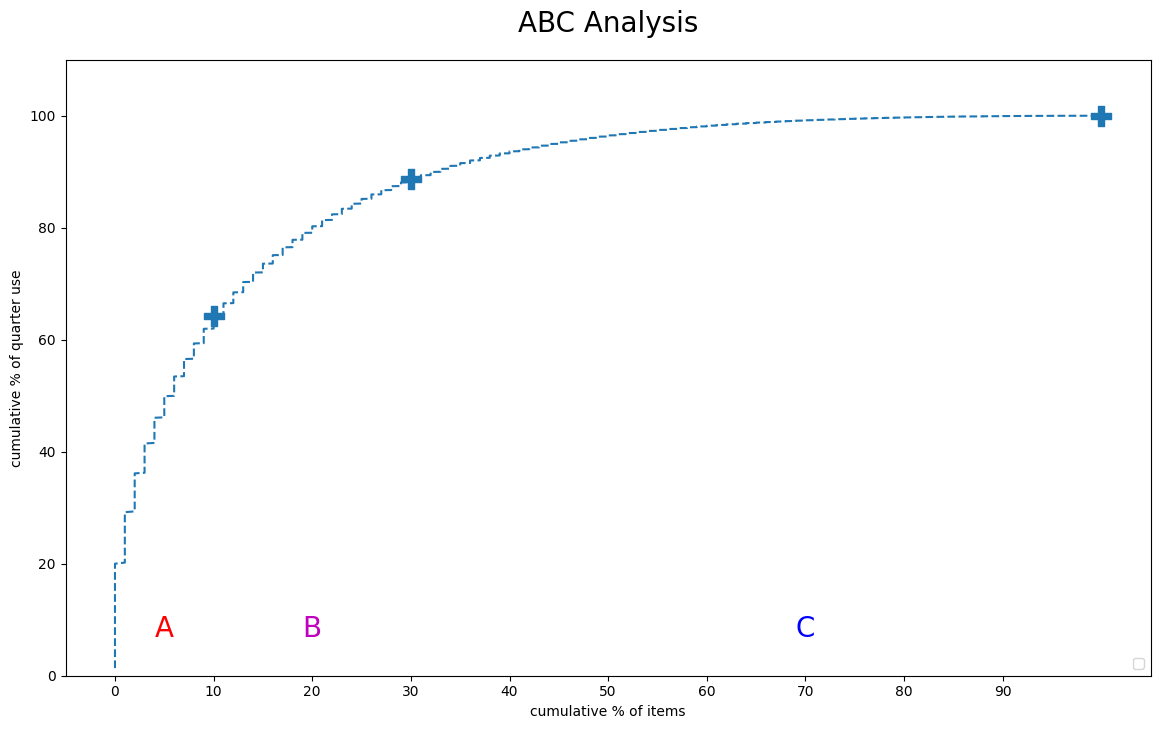

In [91]:
plt.figure(figsize=(14,8))
plt.plot(df['cumulative_%_of_items'], df['cumulative_%_of_quarter_use'],linestyle='dashed')
plt.ylim(0,110)
plt.xlabel('cumulative % of items')
plt.ylabel('cumulative % of quarter use')
plt.scatter(cat['cumulative_percentage_of_items'], cat['cumulative_percentage_of_use_by_value'],s=200,marker='P')
#plt.axvline(10,ymax=0.18,color='r',label='10%')
#plt.axvline(30,ymax=0.442,color='m',label='30%')
#plt.axhline(y=cat['cumulative_percentage_of_use_by_value'][0],xmax=0.09,color='r')
#plt.axhline(y=cat['cumulative_percentage_of_use_by_value'][1],xmax=0.28,color='m')
plt.legend(loc='lower right')
plt.title('ABC Analysis',size=20,pad=20)
plt.annotate('A',xy=(10,10),xytext=(4,7),size=20,color='r')
plt.annotate('B',xy=(10,10),xytext=(19,7),size=20,color='m')
plt.annotate('C',xy=(10,10),xytext=(69,7),size=20,color='b')
_=plt.xticks(np.arange(0,100,10))

In [92]:
new = {}
for i in A:
  new[i] = 'A'
for j in B:
  new[j] = 'B'
for z in C:
  new[z] = 'C'

fourth_p['product_id'] = fourth_p['product_id'].astype(str)
fourth_p["classe"]=fourth_p["product_id"].map(new)
fourth_p['class_num'] = np.NaN

counter = 0
for i in fourth_p.classe:
  if i == 'A':
    fourth_p['class_num'][counter] = int(1)
  if i == 'B':
    fourth_p['class_num'][counter] = int(2)
  if i == 'C':
    fourth_p['class_num'][counter] = int(3)
  counter += 1 

## November 

Same computation for ABC analysis on November

In [93]:
df, A, B, C = ABC_items_pct(nov_p['product_id'].astype(str), nov_p['avg_unit_cost'].astype(float), nov_p['quantity'].astype(int))

df.set_index(df['item'], inplace=True)
df.drop('item',axis=1,inplace=True)

In [94]:
A = A.astype(str)
B = B.astype(str)
C = C.astype(str)
df.index = df.index.astype(str)

In [95]:
category = {'category':['A','B','C'], 
            'percentage_of_items':[df.loc[A]['cumulative_%_of_items'][-1],(df.loc[B]['cumulative_%_of_items'][-1])-(df.loc[A]['cumulative_%_of_items'][-1]),(df.loc[C]['cumulative_%_of_items'][-1])-(df.loc[B]['cumulative_%_of_items'][-1])]}
cat = pd.DataFrame(category)
cat['cumulative_percentage_of_items'] = np.cumsum(cat['percentage_of_items'])
cat['percentage_of_use_by_value'] = [np.sum(df.loc[A]['%_of_use']),np.sum(df.loc[B]['%_of_use']),np.sum(df.loc[C]['%_of_use'])]
cat['cumulative_percentage_of_use_by_value'] = np.cumsum(cat['percentage_of_use_by_value'])
cat

,category,percentage_of_items,cumulative_percentage_of_items,percentage_of_use_by_value,cumulative_percentage_of_use_by_value
0,A,10,10,63.488585,63.488585
1,B,20,30,24.014238,87.502822
2,C,69,99,12.497178,100.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


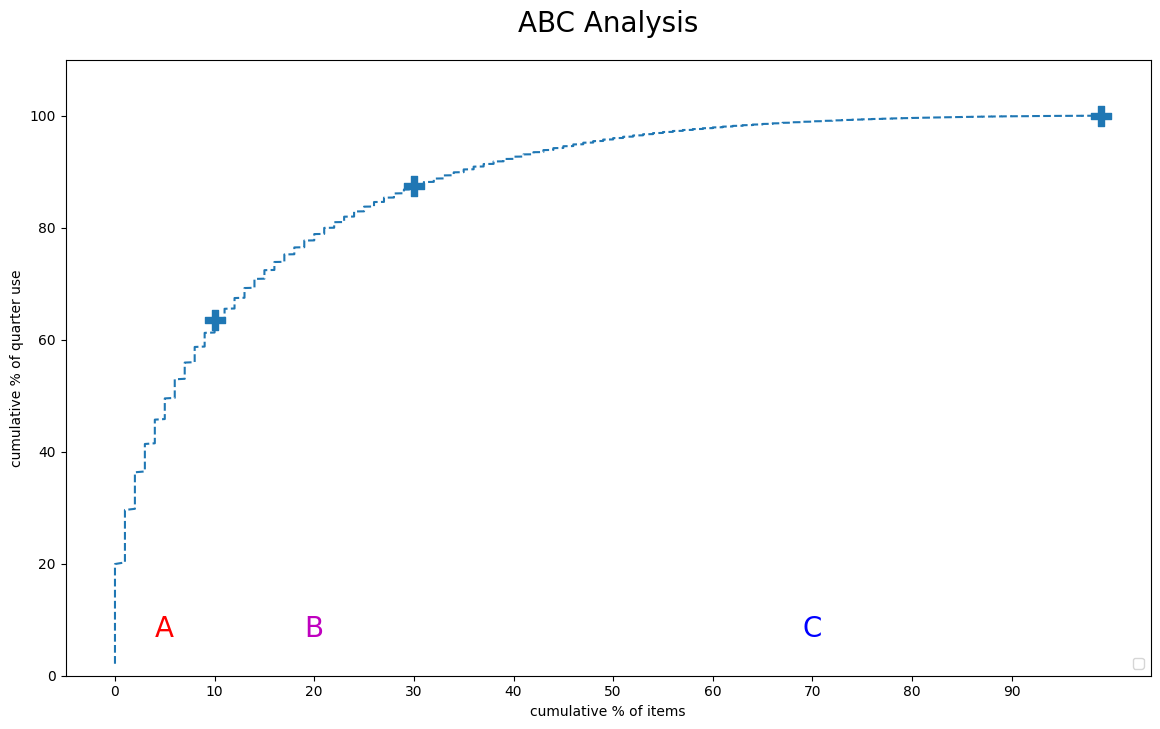

In [96]:
plt.figure(figsize=(14,8))
plt.plot(df['cumulative_%_of_items'], df['cumulative_%_of_quarter_use'],linestyle='dashed')
plt.ylim(0,110)
plt.xlabel('cumulative % of items')
plt.ylabel('cumulative % of quarter use')
plt.scatter(cat['cumulative_percentage_of_items'], cat['cumulative_percentage_of_use_by_value'],s=200,marker='P')
#plt.axvline(10,ymax=0.18,color='r',label='10%')
#plt.axvline(30,ymax=0.442,color='m',label='30%')
#plt.axhline(y=cat['cumulative_percentage_of_use_by_value'][0],xmax=0.09,color='r')
#plt.axhline(y=cat['cumulative_percentage_of_use_by_value'][1],xmax=0.28,color='m')
plt.legend(loc='lower right')
plt.title('ABC Analysis',size=20,pad=20)
plt.annotate('A',xy=(10,10),xytext=(4,7),size=20,color='r')
plt.annotate('B',xy=(10,10),xytext=(19,7),size=20,color='m')
plt.annotate('C',xy=(10,10),xytext=(69,7),size=20,color='b')
_=plt.xticks(np.arange(0,100,10))

In [97]:
new = {}
for i in A:
  new[i] = 'A'
for j in B:
  new[j] = 'B'
for z in C:
  new[z] = 'C'

nov_p['product_id'] = nov_p['product_id'].astype(str)
nov_p["classe"]=nov_p["product_id"].map(new)
nov_p['class_num'] = np.NaN

counter = 0
for i in nov_p.classe:
  if i == 'A':
    nov_p['class_num'][counter] = int(1)
  if i == 'B':
    nov_p['class_num'][counter] = int(2)
  if i == 'C':
    nov_p['class_num'][counter] = int(3)
  counter += 1 

# Printing the final output dataset

In [98]:
first_p

,product_id,quantity,popularity_q_%,rank_quantity,transaction_profit,popularity_p_%,rank_profit,purc_signal,popularity_f_%,rank_frequency,...,avg_%_mark_up,rank_stock,rank_markup,coded_cat1,coded_cat2,coded_cat3,coded_brand,coded_name,classe,class_num
0,110853,502,1.292316,1,157362.1000,0.532753,6,69,78.409091,1,...,12.7599,17,2337,2259,2015,493,522,1709,A,1.0
1,156095,258,0.664178,2,85093.7541,0.288087,31,48,54.545455,6,...,14.9740,2,2105,1163,1267,1176,547,2933,A,1.0
2,107645,178,0.458231,3,31907.3800,0.108023,228,56,63.636364,2,...,14.5062,9,2151,2259,1714,720,522,1782,A,1.0
3,145377,164,0.422191,4,34111.5000,0.115485,204,49,55.681818,5,...,24.2324,13,1328,1375,2519,2668,685,2489,B,2.0
4,157318,158,0.406745,5,67070.4000,0.227068,44,53,60.227273,3,...,13.0917,38,2291,2259,1714,647,522,1825,A,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782,159983,1,0.002574,100,216.0000,0.000731,3586,1,1.136364,51,...,18.0000,1400,1811,1776,1376,694,443,1690,C,3.0
4783,140472,1,0.002574,100,312.0000,0.001056,3491,1,1.136364,51,...,20.5300,1393,1602,1776,1773,1773,730,3251,C,3.0
4784,158028,1,0.002574,100,-1333.0000,-0.004513,4003,1,1.136364,51,...,-13.8200,1400,4036,2880,806,902,367,1944,C,3.0
4785,108946,1,0.002574,100,3049.0000,0.010322,2018,1,1.136364,51,...,23.1000,1391,1410,2180,834,1088,453,1680,C,3.0


In [99]:
second_p

,product_id,quantity,popularity_q_%,rank_quantity,transaction_profit,popularity_p_%,rank_profit,purc_signal,popularity_f_%,rank_frequency,...,avg_%_mark_up,rank_stock,rank_markup,coded_cat1,coded_cat2,coded_cat3,coded_brand,coded_name,classe,class_num
0,112582,270,0.712119,1,-66225.5002,-0.204341,4804,38,42.222222,12,...,5.5363,13,3527,2880,498,1590,253,2462,A,1.0
1,131910,176,0.464196,2,52692.7859,0.162585,89,31,34.444444,19,...,14.3465,91,2416,2259,944,1753,542,3352,A,1.0
2,106100,168,0.443096,3,20840.0000,0.064303,423,18,20.000000,32,...,17.2344,32,2144,2880,2856,1169,309,1937,A,1.0
3,156866,164,0.432546,4,209188.0118,0.645457,9,46,51.111111,4,...,6.4135,44,3415,1676,2005,2467,367,3108,A,1.0
4,156474,157,0.414084,5,145114.6012,0.447756,13,45,50.000000,5,...,6.8007,30,3361,1676,2005,2467,367,2949,A,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5304,157240,1,0.002637,94,3766.0000,0.011620,1990,1,1.111111,49,...,16.4500,1393,2207,1354,1600,1192,455,2974,C,3.0
5305,137475,1,0.002637,94,3370.7308,0.010401,2111,1,1.111111,49,...,23.8700,1395,1535,1676,2832,1282,377,2372,C,3.0
5306,137041,1,0.002637,94,-203.3000,-0.000627,4189,1,1.111111,49,...,-4.4900,1402,4192,1163,1267,1112,621,2575,C,3.0
5307,116267,1,0.002637,94,3318.4195,0.010239,2121,1,1.111111,49,...,5.8600,1403,3492,1676,1258,2032,367,2923,B,2.0


In [100]:
third_p

,product_id,quantity,popularity_q_%,rank_quantity,transaction_profit,popularity_p_%,rank_profit,purc_signal,popularity_f_%,rank_frequency,...,avg_%_mark_up,rank_stock,rank_markup,coded_cat1,coded_cat2,coded_cat3,coded_brand,coded_name,classe,class_num
0,112582,364,0.938991,1,18110.6919,0.052449,515,47,51.086957,6,...,5.0787,73,3515,2880,498,1590,253,2462,A,1.0
1,136250,230,0.593319,2,-28121.0000,-0.081440,4796,35,38.043478,17,...,2.2566,8,3876,2180,613,615,253,1352,A,1.0
2,160649,197,0.508190,3,995592.5206,2.883281,1,32,34.782609,20,...,51.8941,213,394,624,2291,601,543,2194,A,1.0
3,157318,158,0.407584,4,106934.4000,0.309687,32,58,63.043478,2,...,19.4400,14,1872,2259,1714,647,522,1825,A,1.0
4,160654,156,0.402425,5,417078.0027,1.207877,3,35,38.043478,17,...,46.6266,58,528,624,2291,601,543,2197,A,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,159970,1,0.002580,95,-351.0000,-0.001017,4208,1,1.086957,51,...,-10.4800,1329,4440,1776,1376,694,443,1645,C,3.0
5376,158028,1,0.002580,95,1698.0000,0.004917,2730,1,1.086957,51,...,17.6400,1350,2060,2880,806,902,367,1944,C,3.0
5377,165981,1,0.002580,95,707.6250,0.002049,3396,1,1.086957,51,...,22.6500,1339,1587,2259,1714,2431,442,2568,C,3.0
5378,143190,1,0.002580,95,-2836.0000,-0.008213,4519,1,1.086957,51,...,-12.9000,1344,4484,1676,2005,2467,367,2761,C,3.0


In [101]:
fourth_p

,product_id,quantity,popularity_q_%,rank_quantity,transaction_profit,popularity_p_%,rank_profit,purc_signal,popularity_f_%,rank_frequency,...,avg_%_mark_up,rank_stock,rank_markup,coded_cat1,coded_cat2,coded_cat3,coded_brand,coded_name,classe,class_num
0,177925,347,0.696396,1,264994.7810,0.603145,8,37,40.217391,19,...,13.2100,9,2778,2259,944,1753,522,3247,A,1.0
1,110675,274,0.549892,2,-33367.5454,-0.075947,4909,54,58.695652,4,...,10.6248,10,3124,2180,613,2275,544,2531,A,1.0
2,126707,242,0.485671,3,127278.0000,0.289693,33,43,46.739130,13,...,36.2526,33,882,2259,1714,2431,442,2621,A,1.0
3,142254,221,0.443526,4,19912.1226,0.045321,678,52,56.521739,5,...,9.2927,56,3328,2259,944,1763,253,2524,A,1.0
4,156485,211,0.423457,5,658565.4896,1.498938,2,37,40.217391,19,...,8.5946,278,3431,1676,2005,2938,367,3123,A,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5538,159983,1,0.002007,121,125.0000,0.000285,4210,1,1.086957,55,...,10.4200,1636,3155,1776,1376,694,443,1690,C,3.0
5539,143363,1,0.002007,121,826.0000,0.001880,3610,1,1.086957,55,...,33.0500,1587,1032,1375,1564,2715,590,3001,C,3.0
5540,161723,1,0.002007,121,4171.2398,0.009494,2224,1,1.086957,55,...,14.7300,1594,2600,1676,2218,2397,528,3298,C,3.0
5541,137475,1,0.002007,121,1322.5417,0.003010,3283,1,1.086957,55,...,9.1800,1637,3344,1676,2832,1282,377,2372,C,3.0


In [102]:
nov_p

,product_id,quantity,popularity_q_%,rank_quantity,transaction_profit,popularity_p_%,rank_profit,purc_signal,popularity_f_%,rank_frequency,...,avg_%_mark_up,rank_stock,rank_markup,coded_cat1,coded_cat2,coded_cat3,coded_brand,coded_name,classe,class_num
0,156485,133,0.808806,1,453263.9937,3.062792,1,10,34.482759,14,...,10.2500,234,1995,1676,2005,2938,367,3123,A,1.0
1,163385,88,0.535150,2,368919.4514,2.492860,2,25,86.206897,1,...,13.8408,16,1711,2180,613,2175,537,2955,A,1.0
2,139935,88,0.535150,2,9664.0000,0.065302,480,21,72.413793,3,...,17.3843,1,1480,2259,1714,720,345,2164,B,2.0
3,149306,75,0.456093,3,124275.0000,0.839750,9,21,72.413793,3,...,12.2281,39,1847,2880,2856,4877,455,3618,A,1.0
4,177924,65,0.395281,4,33345.0000,0.225319,77,17,58.620690,7,...,18.2400,13,1418,2259,2015,493,522,1901,A,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,158028,1,0.006081,53,1385.0000,0.009359,1864,1,3.448276,23,...,12.3700,1027,1831,2880,806,902,367,1944,C,3.0
3769,157240,1,0.006081,53,2358.0000,0.015933,1488,1,3.448276,23,...,9.7000,922,2044,1354,1600,1192,455,2974,C,3.0
3770,156652,1,0.006081,53,1988.6100,0.013437,1607,1,3.448276,23,...,4.8500,1026,2461,1676,2218,2397,367,3212,B,2.0
3771,127254,1,0.006081,53,2333.8758,0.015770,1495,1,3.448276,23,...,13.3800,1015,1746,1676,2832,1011,289,1800,C,3.0


# Create a final, unique, output Dataset

We select, for each quarter, the interesting variables and we renamed some of them with more user-friendly names

### The otuput dataset "quarters" will be used as input of the dashboard bar-charts.py

In [103]:
quarter1 = first_p[['product_id', 'quantity','rank_quantity',
       'transaction_profit', 'rank_profit', 'purc_signal','rank_frequency', 'clicks_regular', 'clicks_bidding',
       'avg_position_regular', 'avg_position_bidding', 'avg_unit_cost','rank_regular',
       'rank_bidding', 'total_stock', 'avg_%_mark_up', 'rank_stock',
       'rank_markup', 'classe', 'class_num','coded_cat1', 'coded_cat2', 'coded_cat3', 'coded_brand']]
quarter1.rename({'transaction_profit':'total_profit','purc_signal':'days_sold','clicks_regular':'total_regular_clicks','clicks_bidding':'total_bidding_clicks','classe':'ABC_class','class_num':'ABC_class_num','coded_cat1':'category_1', 'coded_cat2':'category_2', 'coded_cat3':'category_3', 'coded_brand':'brand'}, inplace=True,axis=1)
quarter1['quarter'] = '1st_quarter'
quarter1

,product_id,quantity,rank_quantity,total_profit,rank_profit,days_sold,rank_frequency,total_regular_clicks,total_bidding_clicks,avg_position_regular,...,avg_%_mark_up,rank_stock,rank_markup,ABC_class,ABC_class_num,category_1,category_2,category_3,brand,quarter
0,110853,502,1,157362.1000,6,69,1,118.0,NaN,2.35,...,12.7599,17,2337,A,1.0,2259,2015,493,522,1st_quarter
1,156095,258,2,85093.7541,31,48,6,509.0,NaN,1.61,...,14.9740,2,2105,A,1.0,1163,1267,1176,547,1st_quarter
2,107645,178,3,31907.3800,228,56,2,20.0,NaN,7.06,...,14.5062,9,2151,A,1.0,2259,1714,720,522,1st_quarter
3,145377,164,4,34111.5000,204,49,5,22.0,NaN,1.44,...,24.2324,13,1328,B,2.0,1375,2519,2668,685,1st_quarter
4,157318,158,5,67070.4000,44,53,3,111.0,NaN,1.55,...,13.0917,38,2291,A,1.0,2259,1714,647,522,1st_quarter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782,159983,1,100,216.0000,3586,1,51,NaN,NaN,NaN,...,18.0000,1400,1811,C,3.0,1776,1376,694,443,1st_quarter
4783,140472,1,100,312.0000,3491,1,51,NaN,NaN,NaN,...,20.5300,1393,1602,C,3.0,1776,1773,1773,730,1st_quarter
4784,158028,1,100,-1333.0000,4003,1,51,1.0,NaN,1.00,...,-13.8200,1400,4036,C,3.0,2880,806,902,367,1st_quarter
4785,108946,1,100,3049.0000,2018,1,51,NaN,NaN,NaN,...,23.1000,1391,1410,C,3.0,2180,834,1088,453,1st_quarter


In [104]:
quarter2 = second_p[['product_id', 'quantity','rank_quantity',
       'transaction_profit', 'rank_profit', 'purc_signal','rank_frequency', 'clicks_regular', 'clicks_bidding',
       'avg_position_regular', 'avg_position_bidding', 'avg_unit_cost','rank_regular',
       'rank_bidding', 'total_stock', 'avg_%_mark_up', 'rank_stock',
       'rank_markup', 'classe', 'class_num','coded_cat1', 'coded_cat2', 'coded_cat3', 'coded_brand']]
quarter2.rename({'transaction_profit':'total_profit','purc_signal':'days_sold','clicks_regular':'total_regular_clicks','clicks_bidding':'total_bidding_clicks','classe':'ABC_class','class_num':'ABC_class_num','coded_cat1':'category_1', 'coded_cat2':'category_2', 'coded_cat3':'category_3', 'coded_brand':'brand'}, inplace=True,axis=1)
quarter2['quarter'] = '2nd_quarter'
quarter2

,product_id,quantity,rank_quantity,total_profit,rank_profit,days_sold,rank_frequency,total_regular_clicks,total_bidding_clicks,avg_position_regular,...,avg_%_mark_up,rank_stock,rank_markup,ABC_class,ABC_class_num,category_1,category_2,category_3,brand,quarter
0,112582,270,1,-66225.5002,4804,38,12,203.0,210.0,1.75,...,5.5363,13,3527,A,1.0,2880,498,1590,253,2nd_quarter
1,131910,176,2,52692.7859,89,31,19,NaN,NaN,NaN,...,14.3465,91,2416,A,1.0,2259,944,1753,542,2nd_quarter
2,106100,168,3,20840.0000,423,18,32,NaN,NaN,NaN,...,17.2344,32,2144,A,1.0,2880,2856,1169,309,2nd_quarter
3,156866,164,4,209188.0118,9,46,4,29.0,30.0,1.50,...,6.4135,44,3415,A,1.0,1676,2005,2467,367,2nd_quarter
4,156474,157,5,145114.6012,13,45,5,41.0,26.0,1.73,...,6.8007,30,3361,A,1.0,1676,2005,2467,367,2nd_quarter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5304,157240,1,94,3766.0000,1990,1,49,NaN,NaN,NaN,...,16.4500,1393,2207,C,3.0,1354,1600,1192,455,2nd_quarter
5305,137475,1,94,3370.7308,2111,1,49,NaN,NaN,NaN,...,23.8700,1395,1535,C,3.0,1676,2832,1282,377,2nd_quarter
5306,137041,1,94,-203.3000,4189,1,49,NaN,NaN,NaN,...,-4.4900,1402,4192,C,3.0,1163,1267,1112,621,2nd_quarter
5307,116267,1,94,3318.4195,2121,1,49,NaN,NaN,NaN,...,5.8600,1403,3492,B,2.0,1676,1258,2032,367,2nd_quarter


In [105]:
quarter3 = third_p[['product_id', 'quantity','rank_quantity',
       'transaction_profit', 'rank_profit', 'purc_signal','rank_frequency', 'clicks_regular', 'clicks_bidding',
       'avg_position_regular', 'avg_position_bidding', 'avg_unit_cost','rank_regular',
       'rank_bidding', 'total_stock', 'avg_%_mark_up', 'rank_stock',
       'rank_markup', 'classe', 'class_num','coded_cat1', 'coded_cat2', 'coded_cat3', 'coded_brand']]
quarter3.rename({'transaction_profit':'total_profit','purc_signal':'days_sold','clicks_regular':'total_regular_clicks','clicks_bidding':'total_bidding_clicks','classe':'ABC_class','class_num':'ABC_class_num','coded_cat1':'category_1', 'coded_cat2':'category_2', 'coded_cat3':'category_3', 'coded_brand':'brand'}, inplace=True,axis=1)
quarter3['quarter'] = '3rd_quarter'
quarter3

,product_id,quantity,rank_quantity,total_profit,rank_profit,days_sold,rank_frequency,total_regular_clicks,total_bidding_clicks,avg_position_regular,...,avg_%_mark_up,rank_stock,rank_markup,ABC_class,ABC_class_num,category_1,category_2,category_3,brand,quarter
0,112582,364,1,18110.6919,515,47,6,NaN,NaN,NaN,...,5.0787,73,3515,A,1.0,2880,498,1590,253,3rd_quarter
1,136250,230,2,-28121.0000,4796,35,17,NaN,NaN,NaN,...,2.2566,8,3876,A,1.0,2180,613,615,253,3rd_quarter
2,160649,197,3,995592.5206,1,32,20,NaN,NaN,NaN,...,51.8941,213,394,A,1.0,624,2291,601,543,3rd_quarter
3,157318,158,4,106934.4000,32,58,2,17.0,106.0,1.79,...,19.4400,14,1872,A,1.0,2259,1714,647,522,3rd_quarter
4,160654,156,5,417078.0027,3,35,17,71.0,52.0,3.17,...,46.6266,58,528,A,1.0,624,2291,601,543,3rd_quarter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,159970,1,95,-351.0000,4208,1,51,NaN,NaN,NaN,...,-10.4800,1329,4440,C,3.0,1776,1376,694,443,3rd_quarter
5376,158028,1,95,1698.0000,2730,1,51,NaN,NaN,NaN,...,17.6400,1350,2060,C,3.0,2880,806,902,367,3rd_quarter
5377,165981,1,95,707.6250,3396,1,51,NaN,NaN,NaN,...,22.6500,1339,1587,C,3.0,2259,1714,2431,442,3rd_quarter
5378,143190,1,95,-2836.0000,4519,1,51,NaN,NaN,NaN,...,-12.9000,1344,4484,C,3.0,1676,2005,2467,367,3rd_quarter


In [106]:
quarter4 = fourth_p[['product_id', 'quantity','rank_quantity',
       'transaction_profit', 'rank_profit', 'purc_signal','rank_frequency', 'clicks_regular', 'clicks_bidding',
       'avg_position_regular', 'avg_position_bidding', 'avg_unit_cost','rank_regular',
       'rank_bidding', 'total_stock', 'avg_%_mark_up', 'rank_stock',
       'rank_markup', 'classe', 'class_num','coded_cat1', 'coded_cat2', 'coded_cat3', 'coded_brand']]
quarter4.rename({'transaction_profit':'total_profit','purc_signal':'days_sold','clicks_regular':'total_regular_clicks','clicks_bidding':'total_bidding_clicks','classe':'ABC_class','class_num':'ABC_class_num','coded_cat1':'category_1', 'coded_cat2':'category_2', 'coded_cat3':'category_3', 'coded_brand':'brand'}, inplace=True,axis=1)
quarter4['quarter'] = '4th_quarter'
quarter4

,product_id,quantity,rank_quantity,total_profit,rank_profit,days_sold,rank_frequency,total_regular_clicks,total_bidding_clicks,avg_position_regular,...,avg_%_mark_up,rank_stock,rank_markup,ABC_class,ABC_class_num,category_1,category_2,category_3,brand,quarter
0,177925,347,1,264994.7810,8,37,19,35.0,67.0,1.14,...,13.2100,9,2778,A,1.0,2259,944,1753,522,4th_quarter
1,110675,274,2,-33367.5454,4909,54,4,7.0,41.0,1.75,...,10.6248,10,3124,A,1.0,2180,613,2275,544,4th_quarter
2,126707,242,3,127278.0000,33,43,13,10.0,92.0,1.43,...,36.2526,33,882,A,1.0,2259,1714,2431,442,4th_quarter
3,142254,221,4,19912.1226,678,52,5,31.0,130.0,2.73,...,9.2927,56,3328,A,1.0,2259,944,1763,253,4th_quarter
4,156485,211,5,658565.4896,2,37,19,40.0,159.0,3.74,...,8.5946,278,3431,A,1.0,1676,2005,2938,367,4th_quarter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5538,159983,1,121,125.0000,4210,1,55,NaN,NaN,NaN,...,10.4200,1636,3155,C,3.0,1776,1376,694,443,4th_quarter
5539,143363,1,121,826.0000,3610,1,55,NaN,NaN,NaN,...,33.0500,1587,1032,C,3.0,1375,1564,2715,590,4th_quarter
5540,161723,1,121,4171.2398,2224,1,55,NaN,NaN,NaN,...,14.7300,1594,2600,C,3.0,1676,2218,2397,528,4th_quarter
5541,137475,1,121,1322.5417,3283,1,55,NaN,NaN,NaN,...,9.1800,1637,3344,C,3.0,1676,2832,1282,377,4th_quarter


In [107]:
november = nov_p[['product_id', 'quantity','rank_quantity',
       'transaction_profit', 'rank_profit', 'purc_signal','rank_frequency', 'clicks_regular', 'clicks_bidding',
       'avg_position_regular', 'avg_position_bidding', 'avg_unit_cost','rank_regular',
       'rank_bidding', 'total_stock', 'avg_%_mark_up', 'rank_stock',
       'rank_markup', 'classe', 'class_num','coded_cat1', 'coded_cat2', 'coded_cat3', 'coded_brand']]
november.rename({'transaction_profit':'total_profit','purc_signal':'days_sold','clicks_regular':'total_regular_clicks','clicks_bidding':'total_bidding_clicks','classe':'ABC_class','class_num':'ABC_class_num','coded_cat1':'category_1', 'coded_cat2':'category_2', 'coded_cat3':'category_3', 'coded_brand':'brand'}, inplace=True,axis=1)
november['quarter'] = 'november'
november

,product_id,quantity,rank_quantity,total_profit,rank_profit,days_sold,rank_frequency,total_regular_clicks,total_bidding_clicks,avg_position_regular,...,avg_%_mark_up,rank_stock,rank_markup,ABC_class,ABC_class_num,category_1,category_2,category_3,brand,quarter
0,156485,133,1,453263.9937,1,10,14,29.0,123.0,2.88,...,10.2500,234,1995,A,1.0,1676,2005,2938,367,november
1,163385,88,2,368919.4514,2,25,1,95.0,90.0,1.41,...,13.8408,16,1711,A,1.0,2180,613,2175,537,november
2,139935,88,2,9664.0000,480,21,3,16.0,73.0,2.54,...,17.3843,1,1480,B,2.0,2259,1714,720,345,november
3,149306,75,3,124275.0000,9,21,3,169.0,279.0,8.34,...,12.2281,39,1847,A,1.0,2880,2856,4877,455,november
4,177924,65,4,33345.0000,77,17,7,7.0,13.0,7.25,...,18.2400,13,1418,A,1.0,2259,2015,493,522,november
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,158028,1,53,1385.0000,1864,1,23,NaN,NaN,NaN,...,12.3700,1027,1831,C,3.0,2880,806,902,367,november
3769,157240,1,53,2358.0000,1488,1,23,NaN,NaN,NaN,...,9.7000,922,2044,C,3.0,1354,1600,1192,455,november
3770,156652,1,53,1988.6100,1607,1,23,NaN,NaN,NaN,...,4.8500,1026,2461,B,2.0,1676,2218,2397,367,november
3771,127254,1,53,2333.8758,1495,1,23,NaN,NaN,NaN,...,13.3800,1015,1746,C,3.0,1676,2832,1011,289,november


In [108]:
#Concatenating all the quarters togheter, keeping signal of to which quarter (or november) each rows belong to
quarters = pd.concat([quarter1,quarter2,quarter3,quarter4,november])

In [109]:
quarters.sort_values('rank_quantity').head(20)

,product_id,quantity,rank_quantity,total_profit,rank_profit,days_sold,rank_frequency,total_regular_clicks,total_bidding_clicks,avg_position_regular,...,avg_%_mark_up,rank_stock,rank_markup,ABC_class,ABC_class_num,category_1,category_2,category_3,brand,quarter
0,110853,502,1,157362.1000,6,69,1,118.0,NaN,2.35,...,12.7599,17,2337,A,1.0,2259,2015,493,522,1st_quarter
0,112582,364,1,18110.6919,515,47,6,NaN,NaN,NaN,...,5.0787,73,3515,A,1.0,2880,498,1590,253,3rd_quarter
0,177925,347,1,264994.7810,8,37,19,35.0,67.0,1.14,...,13.2100,9,2778,A,1.0,2259,944,1753,522,4th_quarter
0,156485,133,1,453263.9937,1,10,14,29.0,123.0,2.88,...,10.2500,234,1995,A,1.0,1676,2005,2938,367,november
0,112582,270,1,-66225.5002,4804,38,12,203.0,210.0,1.75,...,5.5363,13,3527,A,1.0,2880,498,1590,253,2nd_quarter
1,156095,258,2,85093.7541,31,48,6,509.0,NaN,1.61,...,14.9740,2,2105,A,1.0,1163,1267,1176,547,1st_quarter
2,139935,88,2,9664.0000,480,21,3,16.0,73.0,2.54,...,17.3843,1,1480,B,2.0,2259,1714,720,345,november
1,163385,88,2,368919.4514,2,25,1,95.0,90.0,1.41,...,13.8408,16,1711,A,1.0,2180,613,2175,537,november
1,136250,230,2,-28121.0000,4796,35,17,NaN,NaN,NaN,...,2.2566,8,3876,A,1.0,2180,613,615,253,3rd_quarter
1,131910,176,2,52692.7859,89,31,19,NaN,NaN,NaN,...,14.3465,91,2416,A,1.0,2259,944,1753,542,2nd_quarter


In [110]:
quarters.to_csv('dataset/quarters.csv')